In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('ggplot')

% matplotlib inline

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam, SGD

from datetime import datetime
from dateutil.relativedelta import relativedelta

from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

from funcs_var import *

Using TensorFlow backend.


## Data Collection

#### short term interst rate

In [2]:
stir = pd.read_csv('var_ru/ru_stir.csv')

In [3]:
stir = stir[['TIME', 'Value']].copy()

In [4]:
stir['TIME'] = pd.to_datetime(stir['TIME'])

In [5]:
stir.index = stir['TIME']

In [6]:
stir = stir[['Value']].copy()

In [7]:
stir['date'] = stir.index.tolist()

#### inflation rate

In [8]:
infr = pd.read_csv('var_ru/ru_inf.csv')

In [9]:
infr = infr.sort_index(axis=0, ascending=False).reset_index(drop=True)

In [10]:
inf_l = []
for i in range(len(infr.iloc[:, 1:13])):
    inf_l = inf_l + infr.iloc[i, 1:13].tolist()

In [11]:
inf_l = inf_l[:-8]

In [12]:
for i in range(len(inf_l)):
    inf_l[i] = inf_l[i].replace(',', '.')

In [13]:
for i in range(len(inf_l)):
    inf_l[i] = float(inf_l[i])

In [14]:
date_list = []
for i in range(len(inf_l)):
    date_list.append(datetime.strptime('1991-01', '%Y-%M') + relativedelta(months=i))

In [15]:
infr = pd.DataFrame(inf_l, date_list, ['Value']).iloc[:-4, :]

In [16]:
q_list = []
for y in range(1991, 2017):
    for q in ['Q1', 'Q1', 'Q1', 'Q2', 'Q2', 'Q2', 'Q3', 'Q3', 'Q3', 'Q4', 'Q4', 'Q4']:
        q_list.append(str(y)+q)

In [17]:
infr['q'] = q_list

In [18]:
g = infr.groupby('q')['Value']
quarters = pd.unique(infr['q']).tolist()

In [19]:
ir_q = []
for q in quarters:
    l_g = g.get_group(q).tolist()
    l_g_m = [i*0.01 for i in l_g]
    current = 1
    for i in l_g_m:
        current = current + current*i
    ir_q.append((current-1)*100)

In [20]:
infr = pd.DataFrame([ir_q, pd.to_datetime(quarters).tolist()], ['Value', 'date']).T

#### GDP

In [21]:
gdp = pd.read_csv('var_ru/ru_gdp_real.csv')

In [22]:
gdp_l = gdp.T.iloc[1:, 1].tolist()

In [23]:
for i in range(len(gdp_l)):
    gdp_l[i] = str(gdp_l[i])

In [24]:
for i in range(len(gdp_l)):
    gdp_l[i] = gdp_l[i].replace(',', '.')

In [25]:
for i in range(len(gdp_l)):
    gdp_l[i] = float(gdp_l[i])

In [26]:
date_list = []
for i in range(0, len(gdp_l)*3, 3):
    date_list.append(datetime.strptime('1995-01', '%Y-%m') + relativedelta(months=i))

In [27]:
gdp = pd.DataFrame(gdp_l, date_list, ['Value'])

In [28]:
gdp['date'] = gdp.index.tolist()

#### Make full df

In [29]:
gdp.index = gdp['date']
gdp = gdp[['Value']].copy()
stir.index = stir['date']
stir = stir[['Value']].copy()
infr.index = infr['date']
infr = infr[['Value']].copy()

In [30]:
df_var_t = pd.concat([gdp, stir, infr], axis=1).dropna()
df_var_t.columns = ['gdp', 'stir', 'infr']

Results of Dickey-Fuller Test:
Test Statistic                 -1.359580
p-value                         0.601493
#Lags Used                      1.000000
Number of Observations Used    76.000000
Critical Value (1%)            -3.519481
Critical Value (10%)           -2.587498
Critical Value (5%)            -2.900395
dtype: float64


Results of KPSS Test:
Test Statistic            0.669773
p-value                   0.016293
#Lags Used               12.000000
Critical Value (1%)       0.739000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
dtype: float64


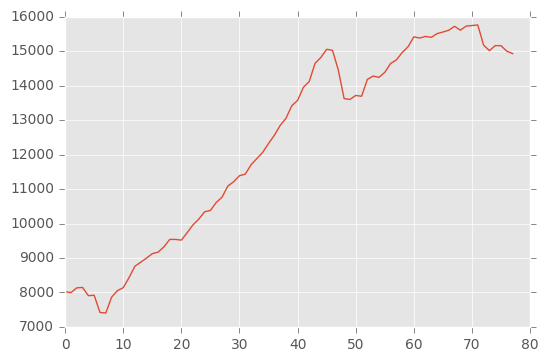

In [31]:
test_stationarity(df_var_t['gdp'])

Results of Dickey-Fuller Test:
Test Statistic                 -1.878809
p-value                         0.342095
#Lags Used                      3.000000
Number of Observations Used    74.000000
Critical Value (1%)            -3.521980
Critical Value (10%)           -2.588072
Critical Value (5%)            -2.901470
dtype: float64


Results of KPSS Test:
Test Statistic            0.375694
p-value                   0.087632
#Lags Used               12.000000
Critical Value (1%)       0.739000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
dtype: float64


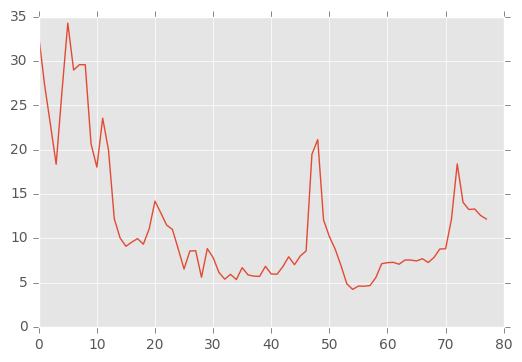

In [32]:
test_stationarity(df_var_t['stir'])

Results of Dickey-Fuller Test:
Test Statistic                 -3.573402
p-value                         0.006290
#Lags Used                     12.000000
Number of Observations Used    65.000000
Critical Value (1%)            -3.535217
Critical Value (10%)           -2.591103
Critical Value (5%)            -2.907154
dtype: float64


Results of KPSS Test:
Test Statistic            0.412117
p-value                   0.071932
#Lags Used               12.000000
Critical Value (1%)       0.739000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
dtype: float64


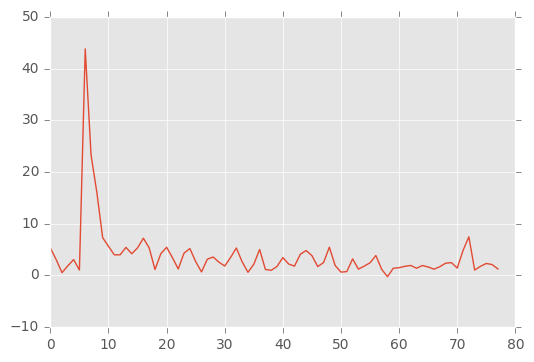

In [33]:
test_stationarity(df_var_t['infr'])

Рвзности

Results of Dickey-Fuller Test:
Test Statistic                 -5.575741
p-value                         0.000001
#Lags Used                      0.000000
Number of Observations Used    76.000000
Critical Value (1%)            -3.519481
Critical Value (10%)           -2.587498
Critical Value (5%)            -2.900395
dtype: float64


Results of KPSS Test:
Test Statistic            0.235576
p-value                   0.100000
#Lags Used               12.000000
Critical Value (1%)       0.739000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
dtype: float64


/home/andrey/anaconda3/envs/neural_net/lib/python3.5/site-packages/statsmodels/tsa/stattools.py:1260: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


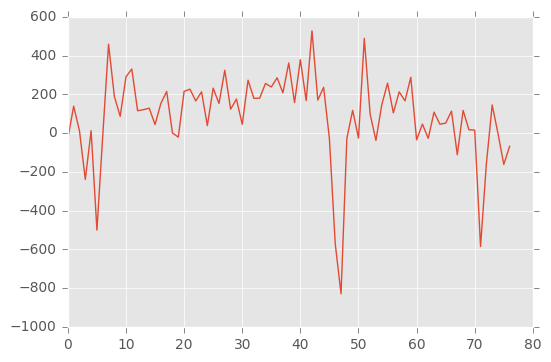

In [34]:
test_stationarity(diff_series(df_var_t['gdp']))

Results of Dickey-Fuller Test:
Test Statistic                -8.596966e+00
p-value                        7.034930e-14
#Lags Used                     1.000000e+00
Number of Observations Used    7.500000e+01
Critical Value (1%)           -3.520713e+00
Critical Value (10%)          -2.587781e+00
Critical Value (5%)           -2.900925e+00
dtype: float64


Results of KPSS Test:
Test Statistic            0.398520
p-value                   0.077793
#Lags Used               12.000000
Critical Value (1%)       0.739000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
dtype: float64


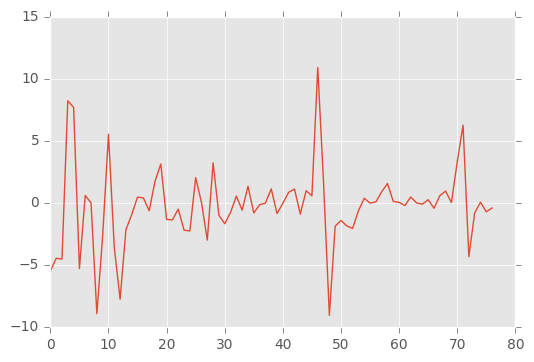

In [35]:
test_stationarity(diff_series(df_var_t['stir']))

Results of Dickey-Fuller Test:
Test Statistic                -7.011675e+00
p-value                        6.896144e-10
#Lags Used                     2.000000e+00
Number of Observations Used    7.400000e+01
Critical Value (1%)           -3.521980e+00
Critical Value (10%)          -2.588072e+00
Critical Value (5%)           -2.901470e+00
dtype: float64


Results of KPSS Test:
Test Statistic            0.08435
p-value                   0.10000
#Lags Used               12.00000
Critical Value (1%)       0.73900
Critical Value (10%)      0.34700
Critical Value (5%)       0.46300
Critical Value (2.5%)     0.57400
dtype: float64


/home/andrey/anaconda3/envs/neural_net/lib/python3.5/site-packages/statsmodels/tsa/stattools.py:1260: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


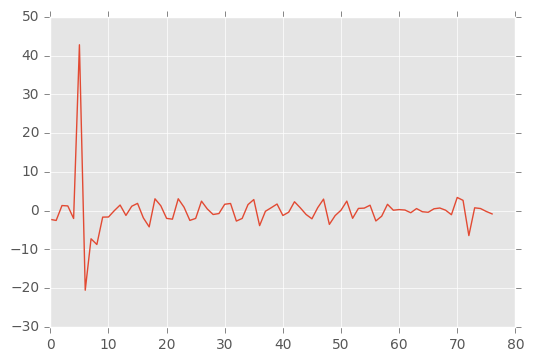

In [36]:
test_stationarity(diff_series(df_var_t['infr']))

In [37]:
df_var_t_diff = diff_series(df_var_t)

## Forecasting

In [38]:
STEPS = 8
LAG = 2

In [39]:
train = df_var_t_diff.iloc[:-STEPS, :]
test = df_var_t_diff.iloc[-STEPS:, :]

train_real = df_var_t.iloc[:-STEPS, :]
test_real = df_var_t.iloc[-STEPS:, :]

### VAR

In [40]:
def var_model(train, steps, lags, years=None, period='m'):
    df = np.array(train)
    years_out=None
    
    b=1
    s=1
    p=steps
    if period=='q':
        p = steps*3
        s=3
        b=3
    
    if years is not None:
        years = pd.to_datetime(years)
        years_out = [pd.to_datetime(years[len(years)-1]) + relativedelta(months=i) for i in range(b, p+1, s)]
    model = VAR(df)
    fitm = model.fit(maxlags=lags)
    var_in = pd.DataFrame(fitm.fittedvalues, 
                          columns=train.columns, 
                          index=years)
    var_out = fitm.forecast(y=df, steps=steps)
    var_out = pd.DataFrame(var_out, 
                           columns=train.columns, 
                           index=years_out)
    return {'in':var_in, 'out':var_out}

In [41]:
var_result = var_model(train, steps=STEPS, lags=LAG, years=train.index[LAG:], period='q')
print(error(var_result['out']['stir'], test['stir']))
print(error(var_result['out']['infr'], test['infr']))
print(error(var_result['out']['gdp'], test['gdp']))

{'mse': 9.2021873001231143, 'mae': 2.1348161627384559, 'rmse': 3.0335107219396993}
{'mse': 10.401732997701956, 'mae': 2.3940491633795222, 'rmse': 3.2251717780146154}
{'mse': 90607.809424190666, 'mae': 220.64130639076689, 'rmse': 301.01131112333746}


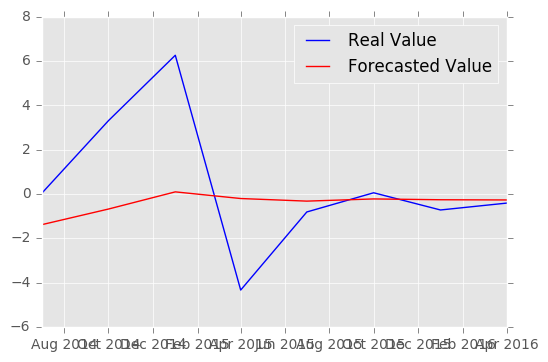

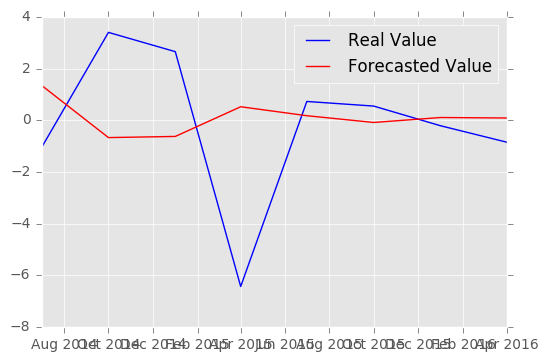

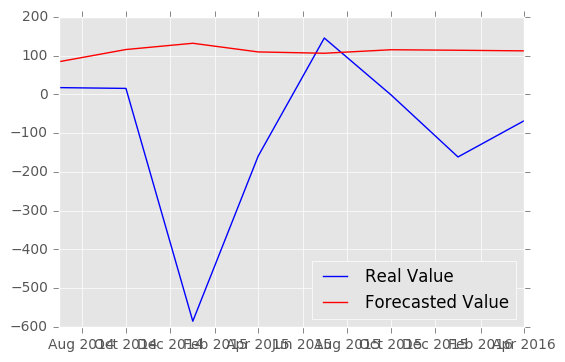

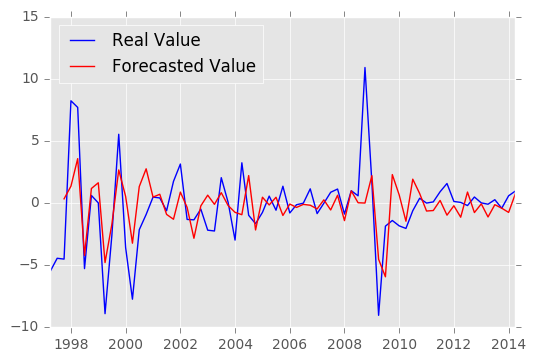

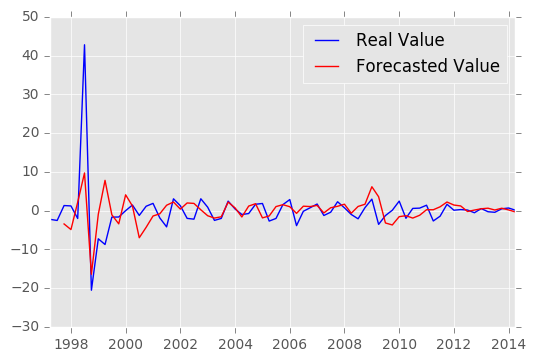

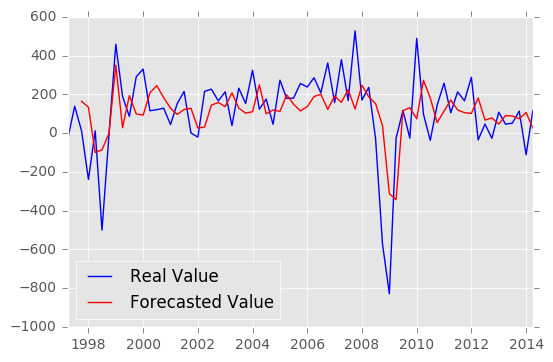

In [42]:
plot_compar(var_result['out']['stir'], test['stir'])
plot_compar(var_result['out']['infr'], test['infr'])
plot_compar(var_result['out']['gdp'], test['gdp'])
plot_compar(var_result['in']['stir'], train['stir'])
plot_compar(var_result['in']['infr'], train['infr'])
plot_compar(var_result['in']['gdp'], train['gdp'])

{'mse': 51.320767294431406, 'mae': 6.6736083461450653, 'rmse': 7.1638514288357076}
{'mse': 5.6852860830489398, 'mae': 2.0641851883922198, 'rmse': 2.3843837952496112}
{'mse': 1251762.9326135281, 'mae': 976.19698979837108, 'rmse': 1118.8221183966323}


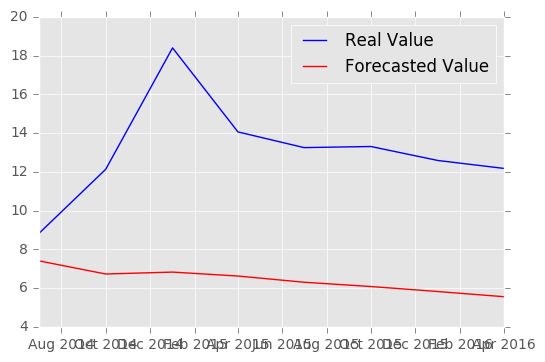

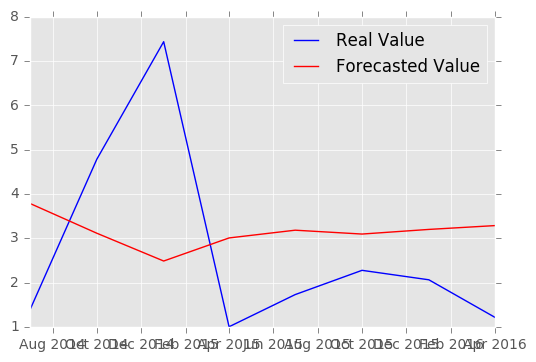

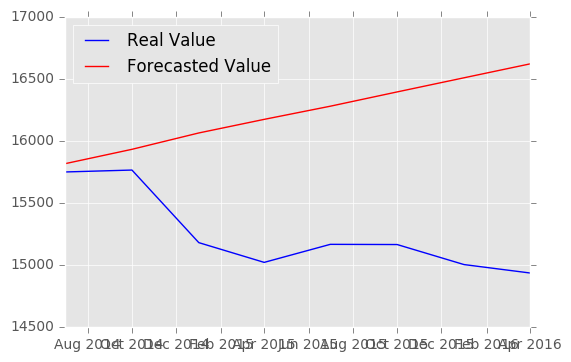

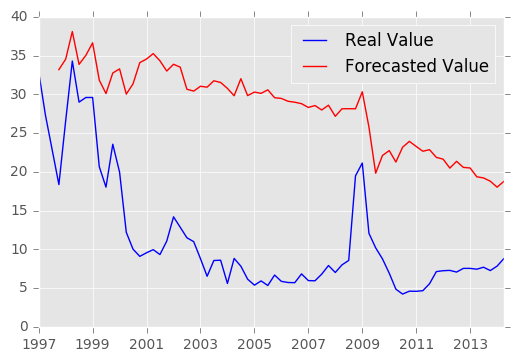

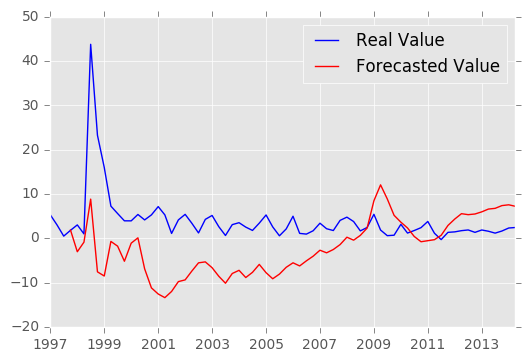

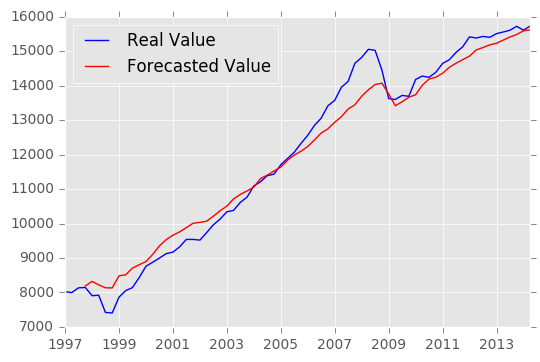

In [43]:
var_undiff_out = undiff(previous_df=train_real, diff_df=var_result['out'])
var_undiff_in = undiff(previous_df=train_real.head(1), diff_df=var_result['in'])
print(error(var_undiff_out['stir'], test_real['stir']))
print(error(var_undiff_out['infr'], test_real['infr']))
print(error(var_undiff_out['gdp'], test_real['gdp']))
plot_compar(var_undiff_out['stir'], test_real['stir'])
plot_compar(var_undiff_out['infr'], test_real['infr'])
plot_compar(var_undiff_out['gdp'], test_real['gdp'])
plot_compar(var_undiff_in['stir'], train_real['stir'])
plot_compar(var_undiff_in['infr'], train_real['infr'])
plot_compar(var_undiff_in['gdp'], train_real['gdp'])

## ANN

In [44]:
df_nn = nn_transform(train, n=LAG)
df_nn_s, m, s = scaler(df_nn)
train_nn_x = df_nn_s.iloc[:, 3:].copy()
train_nn_y = df_nn_s.iloc[:, :3].copy()

In [45]:
def nn_model(x, y, n_feat, lag, steps, model, years=None, epoch=100, period='q'):
    years_out=None
    
    b=1
    s=1
    p=steps
    if period=='q':
        p = steps*3
        s=3
        b=3
    
    if years is not None:
        years = pd.to_datetime(years)
        years_out = [pd.to_datetime(years[len(years)-1]) + relativedelta(months=i) for i in range(b, p+1, s)]
    model.fit(np.array(x), np.array(y),
       nb_epoch=epoch, 
       verbose=2,
       batch_size=1)
    nn_in = pd.DataFrame(model.predict(np.array(x)), 
                         columns=y.columns, 
                         index=years)
    nn_out = nn_predict(model, train, lags=lag, steps=steps)
    if years is not None:
        nn_out.index = years_out
    return {'in':nn_in, 'out':nn_out}

Первый запуск

In [46]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)

In [47]:
nn_result = nn_model(train_nn_x, train_nn_y, 
                     n_feat=3, lag=LAG, steps=STEPS, model=nn, 
                     years=train_nn_y.index, 
                     epoch=500)
nn_result_as = {'in':scaler_back(nn_result['in'], m, s)[train_real.columns.tolist()], 
                'out':scaler_back(nn_result['out'], m, s)[train_real.columns.tolist()]}

Epoch 1/500
0s - loss: 1.1608
Epoch 2/500
0s - loss: 1.0429
Epoch 3/500
0s - loss: 1.0103
Epoch 4/500
0s - loss: 0.9971
Epoch 5/500
0s - loss: 0.9883
Epoch 6/500
0s - loss: 0.9895
Epoch 7/500
0s - loss: 0.9814
Epoch 8/500
0s - loss: 0.9819
Epoch 9/500
0s - loss: 0.9807
Epoch 10/500
0s - loss: 0.9753
Epoch 11/500
0s - loss: 0.9743
Epoch 12/500
0s - loss: 0.9707
Epoch 13/500
0s - loss: 0.9656
Epoch 14/500
0s - loss: 0.9605
Epoch 15/500
0s - loss: 0.9606
Epoch 16/500
0s - loss: 0.9574
Epoch 17/500
0s - loss: 0.9529
Epoch 18/500
0s - loss: 0.9533
Epoch 19/500
0s - loss: 0.9486
Epoch 20/500
0s - loss: 0.9425
Epoch 21/500
0s - loss: 0.9403
Epoch 22/500
0s - loss: 0.9387
Epoch 23/500
0s - loss: 0.9346
Epoch 24/500
0s - loss: 0.9319
Epoch 25/500
0s - loss: 0.9286
Epoch 26/500
0s - loss: 0.9249
Epoch 27/500
0s - loss: 0.9217
Epoch 28/500
0s - loss: 0.9166
Epoch 29/500
0s - loss: 0.9150
Epoch 30/500
0s - loss: 0.9115
Epoch 31/500
0s - loss: 0.9105
Epoch 32/500
0s - loss: 0.9055
Epoch 33/500
0s -

{'mse': 13.073763835579378, 'mae': 2.3976803378658591, 'rmse': 3.6157660095171229}
{'mse': 23.043118570117624, 'mae': 3.241514006742956, 'rmse': 4.8003248400621414}
{'mse': 120052.16085141992, 'mae': 254.37897683836258, 'rmse': 346.48544103817682}


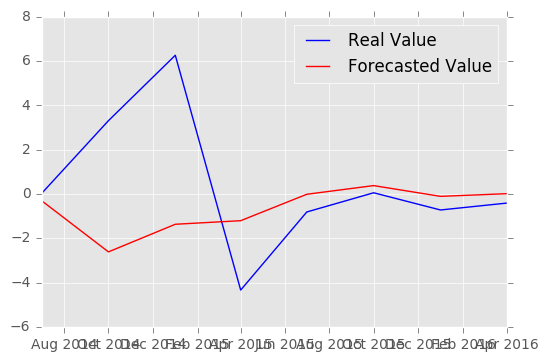

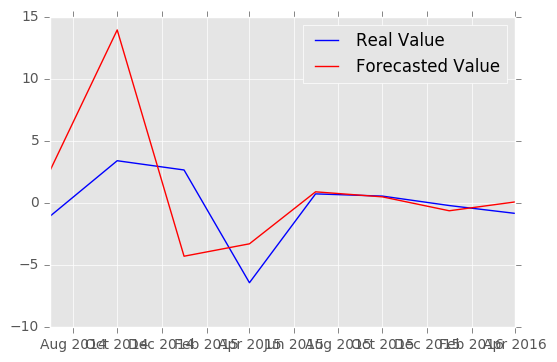

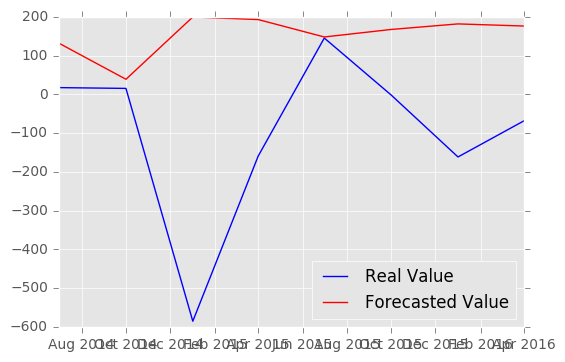

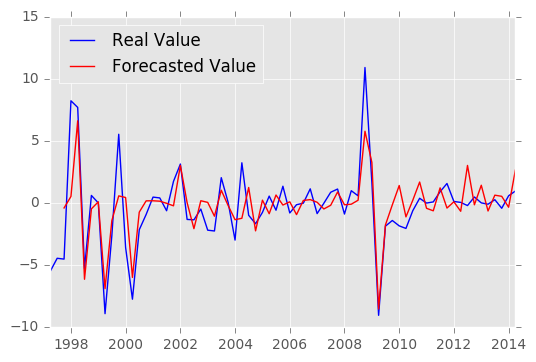

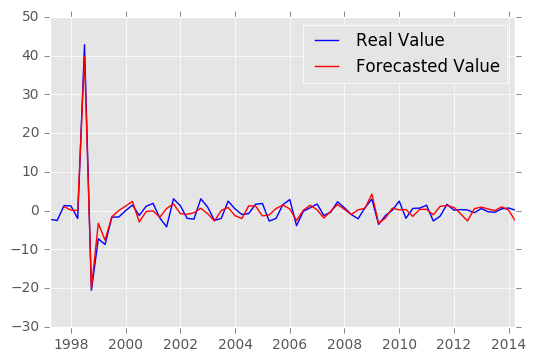

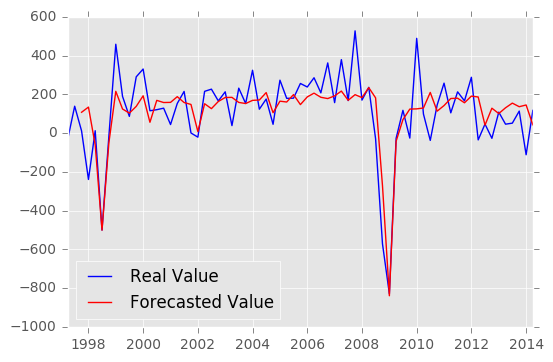

In [48]:
print(error(nn_result_as['out']['stir'], test['stir']))
print(error(nn_result_as['out']['infr'], test['infr']))
print(error(nn_result_as['out']['gdp'], test['gdp']))

plot_compar(nn_result_as['out']['stir'], test['stir'])
plot_compar(nn_result_as['out']['infr'], test['infr'])
plot_compar(nn_result_as['out']['gdp'], test['gdp'])
plot_compar(nn_result_as['in']['stir'], train['stir'])
plot_compar(nn_result_as['in']['infr'], train['infr'])
plot_compar(nn_result_as['in']['gdp'], train['gdp'])

{'mse': 86.803077784576232, 'mae': 8.5503319913958862, 'rmse': 9.3168169341560123}
{'mse': 103.56733098044147, 'mae': 9.7600911359551432, 'rmse': 10.176803573836015}
{'mse': 1698291.3807139471, 'mae': 1125.22201903925, 'rmse': 1303.1850907349835}


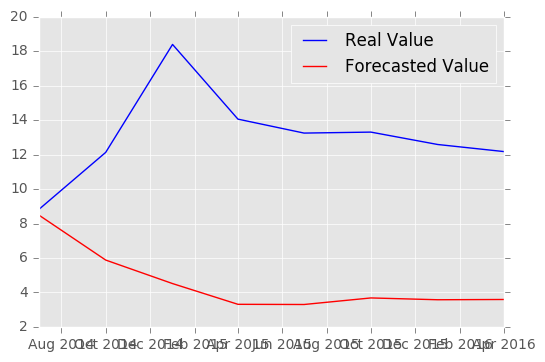

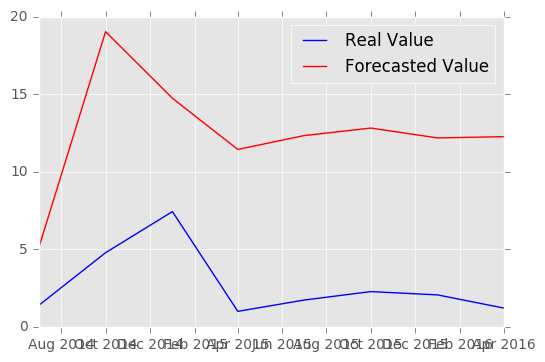

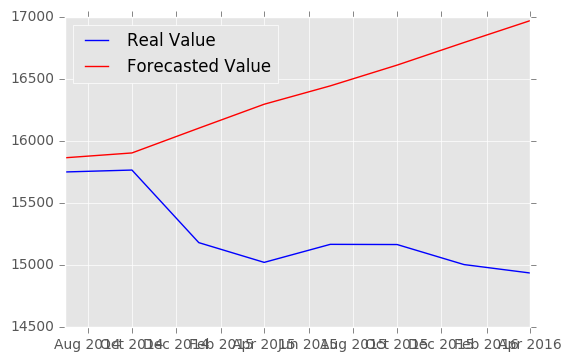

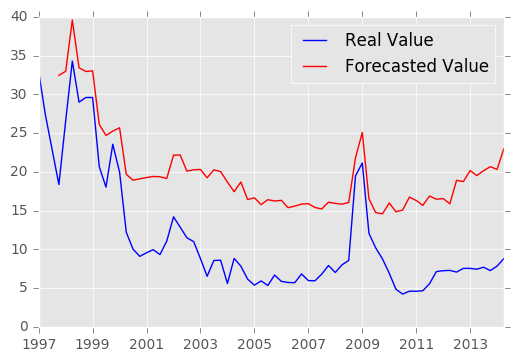

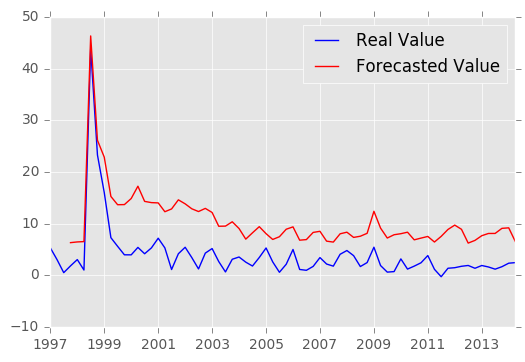

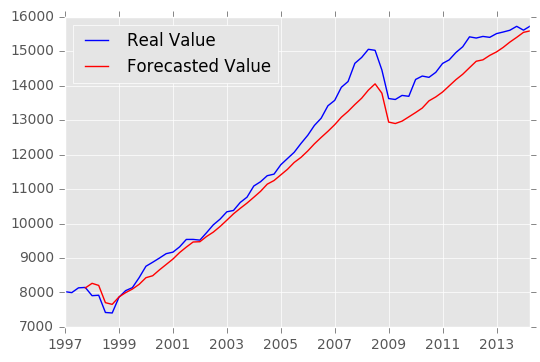

In [49]:
nn_undiff_out = undiff(previous_df=train_real, diff_df=nn_result_as['out'])
nn_undiff_in = undiff(previous_df=train_real.head(1), diff_df=nn_result_as['in'])
print(error(nn_undiff_out['stir'], test_real['stir']))
print(error(nn_undiff_out['infr'], test_real['infr']))
print(error(nn_undiff_out['gdp'], test_real['gdp']))
plot_compar(nn_undiff_out['stir'], test_real['stir'])
plot_compar(nn_undiff_out['infr'], test_real['infr'])
plot_compar(nn_undiff_out['gdp'], test_real['gdp'])
plot_compar(nn_undiff_in['stir'], train_real['stir'])
plot_compar(nn_undiff_in['infr'], train_real['infr'])
plot_compar(nn_undiff_in['gdp'], train_real['gdp'])

Второй запуск

In [50]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
nn_result = nn_model(train_nn_x, train_nn_y, 
                     n_feat=3, lag=LAG, steps=STEPS, model=nn, 
                     years=train_nn_y.index, 
                     epoch=600)
nn_result_as = {'in':scaler_back(nn_result['in'], m, s)[train_real.columns.tolist()], 
                'out':scaler_back(nn_result['out'], m, s)[train_real.columns.tolist()]}

Epoch 1/600
0s - loss: 1.2904
Epoch 2/600
0s - loss: 1.0973
Epoch 3/600
0s - loss: 1.0197
Epoch 4/600
0s - loss: 0.9889
Epoch 5/600
0s - loss: 0.9785
Epoch 6/600
0s - loss: 0.9713
Epoch 7/600
0s - loss: 0.9640
Epoch 8/600
0s - loss: 0.9613
Epoch 9/600
0s - loss: 0.9606
Epoch 10/600
0s - loss: 0.9562
Epoch 11/600
0s - loss: 0.9515
Epoch 12/600
0s - loss: 0.9491
Epoch 13/600
0s - loss: 0.9477
Epoch 14/600
0s - loss: 0.9454
Epoch 15/600
0s - loss: 0.9391
Epoch 16/600
0s - loss: 0.9387
Epoch 17/600
0s - loss: 0.9362
Epoch 18/600
0s - loss: 0.9333
Epoch 19/600
0s - loss: 0.9288
Epoch 20/600
0s - loss: 0.9263
Epoch 21/600
0s - loss: 0.9258
Epoch 22/600
0s - loss: 0.9225
Epoch 23/600
0s - loss: 0.9183
Epoch 24/600
0s - loss: 0.9151
Epoch 25/600
0s - loss: 0.9115
Epoch 26/600
0s - loss: 0.9118
Epoch 27/600
0s - loss: 0.9081
Epoch 28/600
0s - loss: 0.9067
Epoch 29/600
0s - loss: 0.9014
Epoch 30/600
0s - loss: 0.8997
Epoch 31/600
0s - loss: 0.8988
Epoch 32/600
0s - loss: 0.8922
Epoch 33/600
0s -

{'mse': 28.823076984749605, 'mae': 3.8291162491119231, 'rmse': 5.3687127865764621}
{'mse': 64.569954662856134, 'mae': 5.6916643584717903, 'rmse': 8.0355432089471179}
{'mse': 134669.84265991187, 'mae': 286.38175921543893, 'rmse': 366.97389915348458}


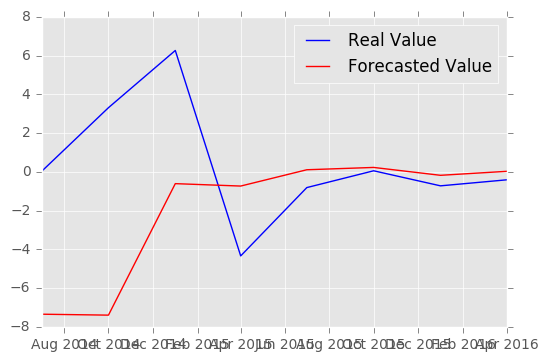

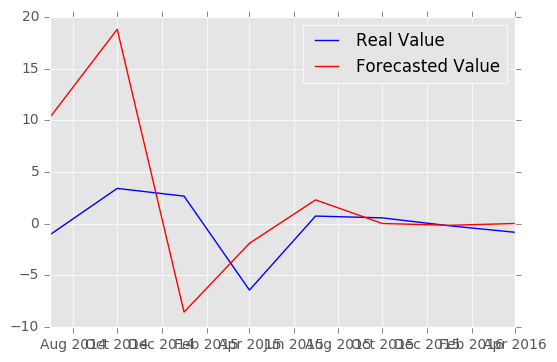

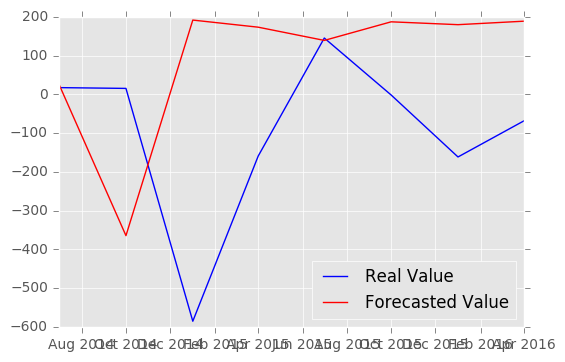

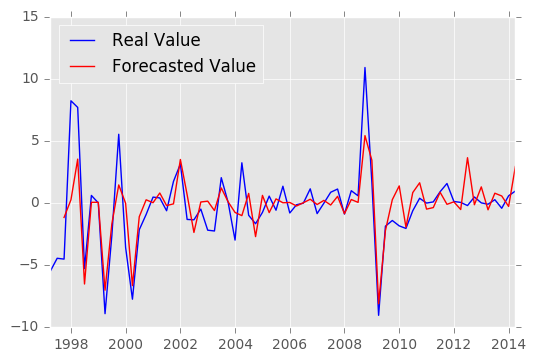

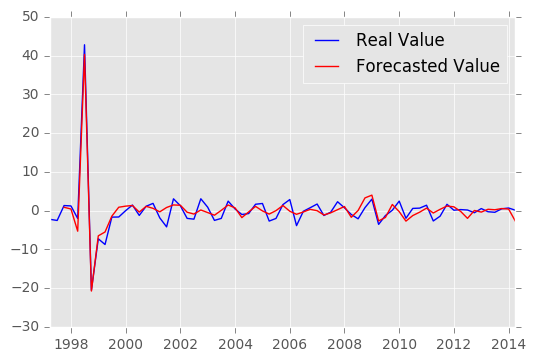

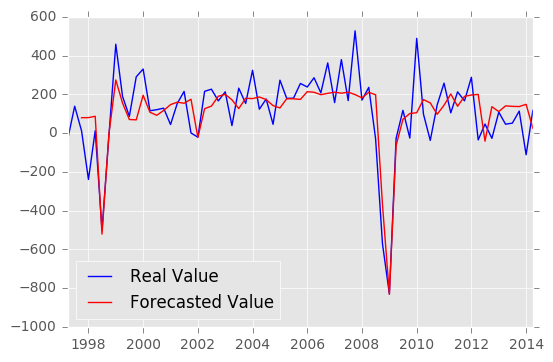

In [51]:
print(error(nn_result_as['out']['stir'], test['stir']))
print(error(nn_result_as['out']['infr'], test['infr']))
print(error(nn_result_as['out']['gdp'], test['gdp']))

plot_compar(nn_result_as['out']['stir'], test['stir'])
plot_compar(nn_result_as['out']['infr'], test['infr'])
plot_compar(nn_result_as['out']['gdp'], test['gdp'])
plot_compar(nn_result_as['in']['stir'], train['stir'])
plot_compar(nn_result_as['in']['infr'], train['infr'])
plot_compar(nn_result_as['in']['gdp'], train['gdp'])

{'mse': 380.83880591417392, 'mae': 18.926099361774501, 'rmse': 19.5150917475213}
{'mse': 417.42735862919665, 'mae': 19.969244597948922, 'rmse': 20.431039098127062}
{'mse': 765995.57317467581, 'mae': 744.41305156395788, 'rmse': 875.21173048278774}


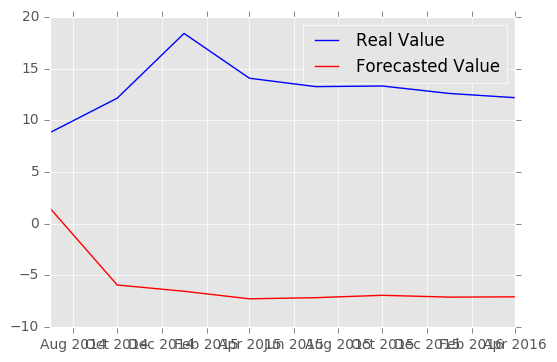

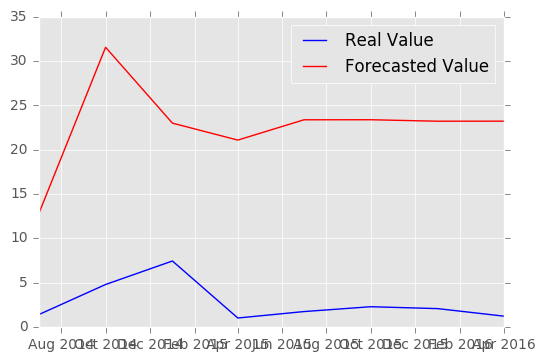

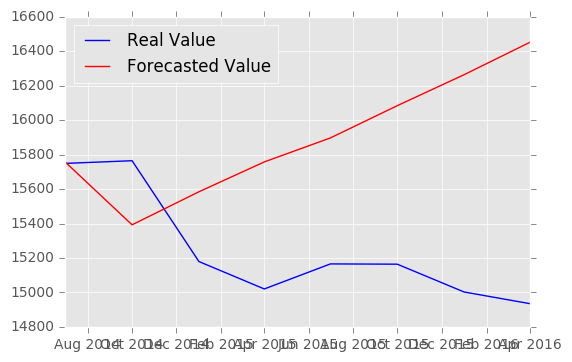

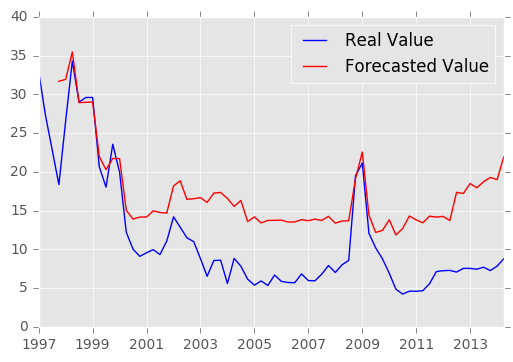

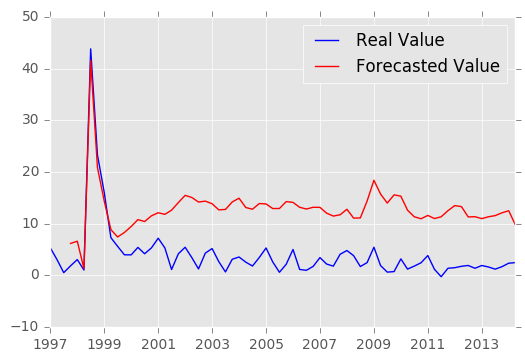

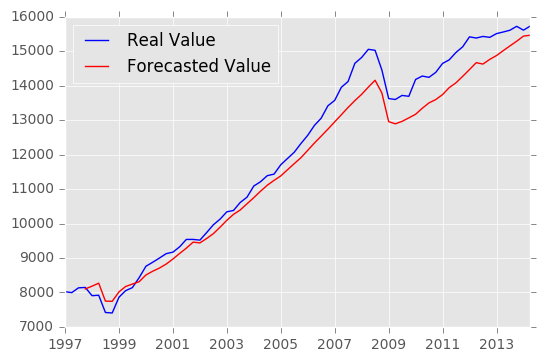

In [52]:
nn_undiff_out = undiff(previous_df=train_real, diff_df=nn_result_as['out'])
nn_undiff_in = undiff(previous_df=train_real.head(1), diff_df=nn_result_as['in'])
print(error(nn_undiff_out['stir'], test_real['stir']))
print(error(nn_undiff_out['infr'], test_real['infr']))
print(error(nn_undiff_out['gdp'], test_real['gdp']))
plot_compar(nn_undiff_out['stir'], test_real['stir'])
plot_compar(nn_undiff_out['infr'], test_real['infr'])
plot_compar(nn_undiff_out['gdp'], test_real['gdp'])
plot_compar(nn_undiff_in['stir'], train_real['stir'])
plot_compar(nn_undiff_in['infr'], train_real['infr'])
plot_compar(nn_undiff_in['gdp'], train_real['gdp'])

С DropOut

In [53]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
nn_result = nn_model(train_nn_x, train_nn_y, 
                     n_feat=3, lag=LAG, steps=STEPS, model=nn, 
                     years=train_nn_y.index, 
                     epoch=600)

Epoch 1/600
0s - loss: 1.1434
Epoch 2/600
0s - loss: 1.0441
Epoch 3/600
0s - loss: 1.0489
Epoch 4/600
0s - loss: 0.9629
Epoch 5/600
0s - loss: 0.9840
Epoch 6/600
0s - loss: 0.9900
Epoch 7/600
0s - loss: 0.9751
Epoch 8/600
0s - loss: 1.0047
Epoch 9/600
0s - loss: 0.9964
Epoch 10/600
0s - loss: 1.0045
Epoch 11/600
0s - loss: 1.0089
Epoch 12/600
0s - loss: 1.0093
Epoch 13/600
0s - loss: 0.9956
Epoch 14/600
0s - loss: 1.0051
Epoch 15/600
0s - loss: 0.9879
Epoch 16/600
0s - loss: 0.9783
Epoch 17/600
0s - loss: 0.9934
Epoch 18/600
0s - loss: 0.9790
Epoch 19/600
0s - loss: 0.9863
Epoch 20/600
0s - loss: 0.9887
Epoch 21/600
0s - loss: 0.9961
Epoch 22/600
0s - loss: 1.0039
Epoch 23/600
0s - loss: 1.0001
Epoch 24/600
0s - loss: 0.9863
Epoch 25/600
0s - loss: 0.9895
Epoch 26/600
0s - loss: 0.9803
Epoch 27/600
0s - loss: 0.9876
Epoch 28/600
0s - loss: 0.9808
Epoch 29/600
0s - loss: 0.9859
Epoch 30/600
0s - loss: 0.9933
Epoch 31/600
0s - loss: 0.9753
Epoch 32/600
0s - loss: 0.9691
Epoch 33/600
0s -

{'mse': 10.650036501920642, 'mae': 2.1756383242898294, 'rmse': 3.263439366974763}
{'mse': 9.0503677208032229, 'mae': 2.1067993885410288, 'rmse': 3.0083829079429405}
{'mse': 109621.9328552798, 'mae': 257.91987509273531, 'rmse': 331.09203079397696}


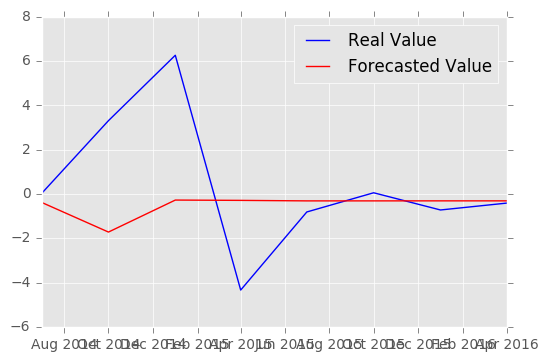

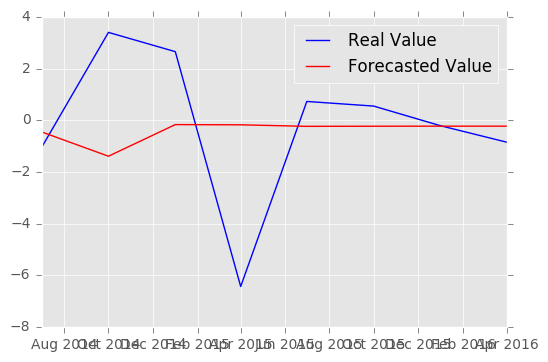

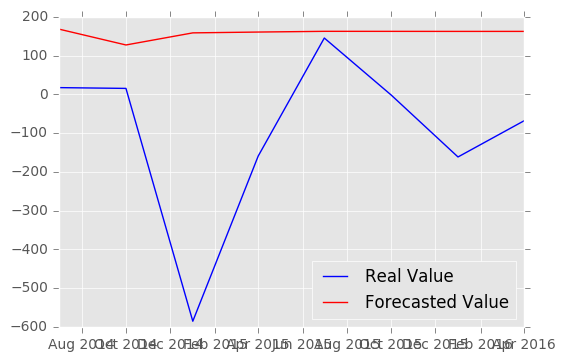

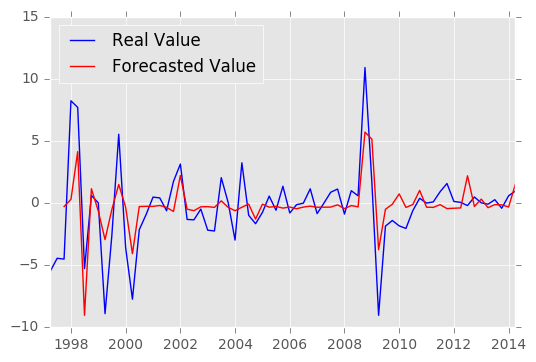

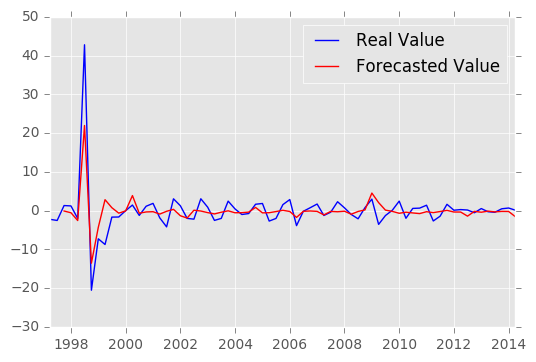

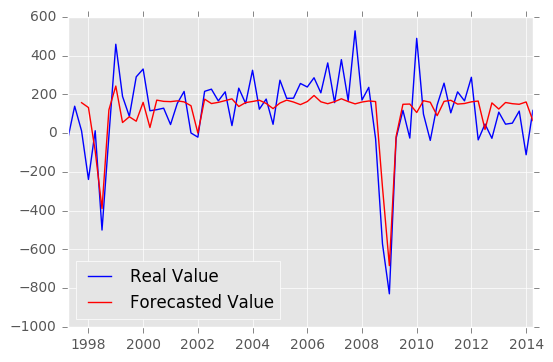

In [54]:
nn_result_as = {'in':scaler_back(nn_result['in'], m, s)[train_real.columns.tolist()], 
                'out':scaler_back(nn_result['out'], m, s)[train_real.columns.tolist()]}
print(error(nn_result_as['out']['stir'], test['stir']))
print(error(nn_result_as['out']['infr'], test['infr']))
print(error(nn_result_as['out']['gdp'], test['gdp']))

plot_compar(nn_result_as['out']['stir'], test['stir'])
plot_compar(nn_result_as['out']['infr'], test['infr'])
plot_compar(nn_result_as['out']['gdp'], test['gdp'])
plot_compar(nn_result_as['in']['stir'], train['stir'])
plot_compar(nn_result_as['in']['infr'], train['infr'])
plot_compar(nn_result_as['in']['gdp'], train['gdp'])

{'mse': 57.38605587049301, 'mae': 6.9510458656320466, 'rmse': 7.5753584648182164}
{'mse': 10.861396164357718, 'mae': 2.6503975847174464, 'rmse': 3.2956632358840485}
{'mse': 1820966.0255873522, 'mae': 1187.1723063844588, 'rmse': 1349.431741729589}


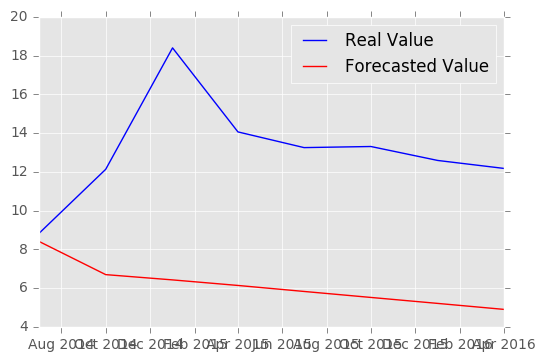

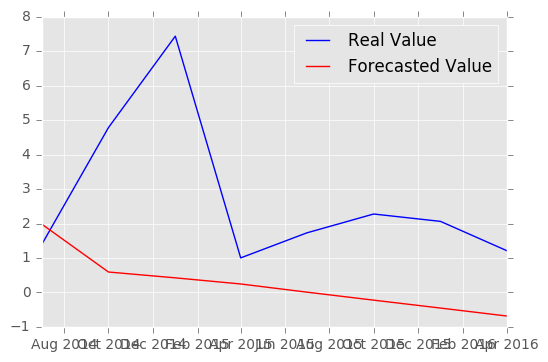

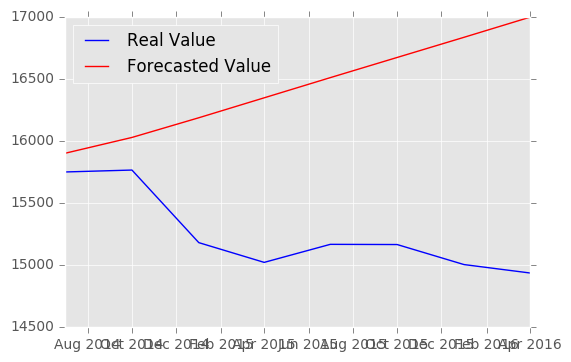

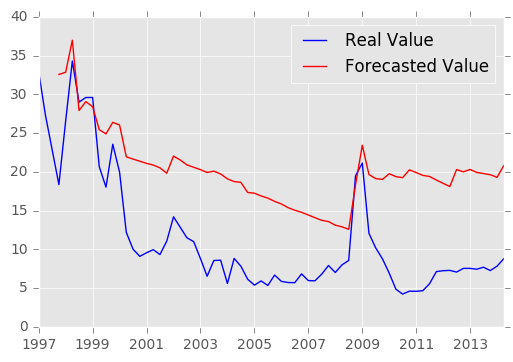

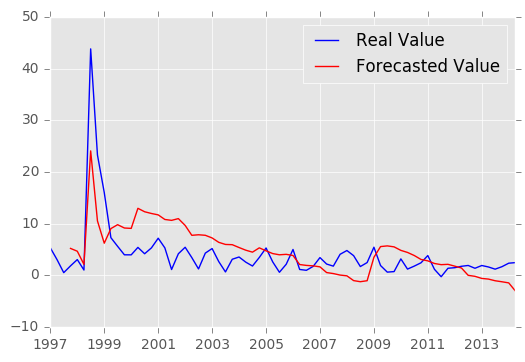

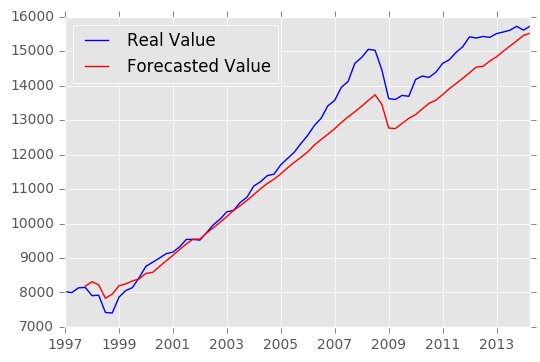

In [55]:
nn_undiff_out = undiff(previous_df=train_real, diff_df=nn_result_as['out'])
nn_undiff_in = undiff(previous_df=train_real.head(1), diff_df=nn_result_as['in'])
print(error(nn_undiff_out['stir'], test_real['stir']))
print(error(nn_undiff_out['infr'], test_real['infr']))
print(error(nn_undiff_out['gdp'], test_real['gdp']))
plot_compar(nn_undiff_out['stir'], test_real['stir'])
plot_compar(nn_undiff_out['infr'], test_real['infr'])
plot_compar(nn_undiff_out['gdp'], test_real['gdp'])
plot_compar(nn_undiff_in['stir'], train_real['stir'])
plot_compar(nn_undiff_in['infr'], train_real['infr'])
plot_compar(nn_undiff_in['gdp'], train_real['gdp'])

На оригинальных данных, а не разницах

In [56]:
df_nn = nn_transform(train_real, n=LAG)
df_nn_s, m, s = scaler(df_nn)
train_nn_x = df_nn_s.iloc[:, 3:].copy()
train_nn_y = df_nn_s.iloc[:, :3].copy()

In [57]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
nn_result = nn_model(train_nn_x, train_nn_y, 
                     n_feat=3, lag=LAG, steps=STEPS, model=nn, 
                     years=train_nn_y.index, 
                     epoch=600)

Epoch 1/600
0s - loss: 1.3732
Epoch 2/600
0s - loss: 1.0934
Epoch 3/600
0s - loss: 0.9619
Epoch 4/600
0s - loss: 0.8908
Epoch 5/600
0s - loss: 0.8410
Epoch 6/600
0s - loss: 0.8018
Epoch 7/600
0s - loss: 0.7555
Epoch 8/600
0s - loss: 0.7170
Epoch 9/600
0s - loss: 0.6742
Epoch 10/600
0s - loss: 0.6369
Epoch 11/600
0s - loss: 0.6008
Epoch 12/600
0s - loss: 0.5698
Epoch 13/600
0s - loss: 0.5428
Epoch 14/600
0s - loss: 0.5184
Epoch 15/600
0s - loss: 0.5012
Epoch 16/600
0s - loss: 0.4826
Epoch 17/600
0s - loss: 0.4729
Epoch 18/600
0s - loss: 0.4610
Epoch 19/600
0s - loss: 0.4518
Epoch 20/600
0s - loss: 0.4451
Epoch 21/600
0s - loss: 0.4396
Epoch 22/600
0s - loss: 0.4361
Epoch 23/600
0s - loss: 0.4321
Epoch 24/600
0s - loss: 0.4293
Epoch 25/600
0s - loss: 0.4248
Epoch 26/600
0s - loss: 0.4223
Epoch 27/600
0s - loss: 0.4180
Epoch 28/600
0s - loss: 0.4144
Epoch 29/600
0s - loss: 0.4116
Epoch 30/600
0s - loss: 0.4087
Epoch 31/600
0s - loss: 0.4057
Epoch 32/600
0s - loss: 0.4043
Epoch 33/600
0s -

{'mse': 10.71256076420444, 'mae': 2.3023949405825799, 'rmse': 3.2730048524565984}
{'mse': 4.9168223037985674, 'mae': 1.6316101644893246, 'rmse': 2.2173908775402156}
{'mse': 2164091.9583367361, 'mae': 1306.2519207298583, 'rmse': 1471.0852994767965}


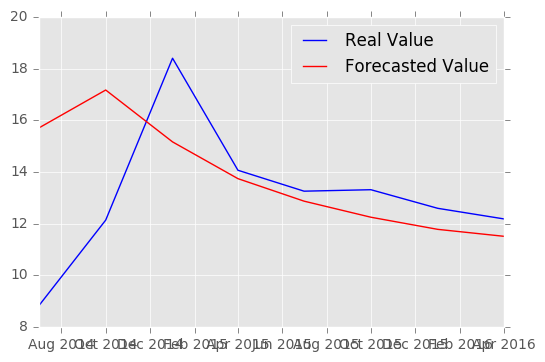

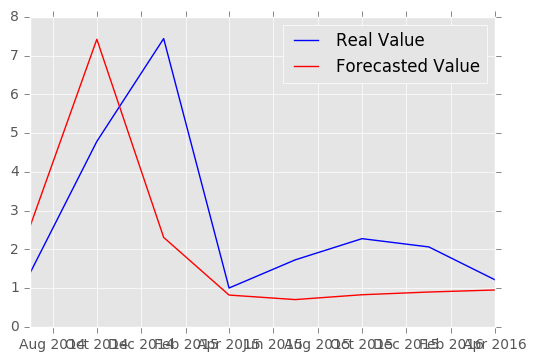

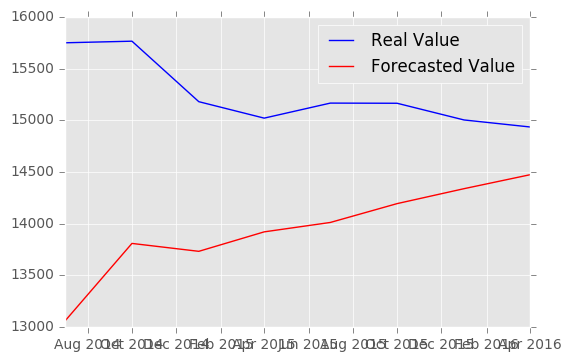

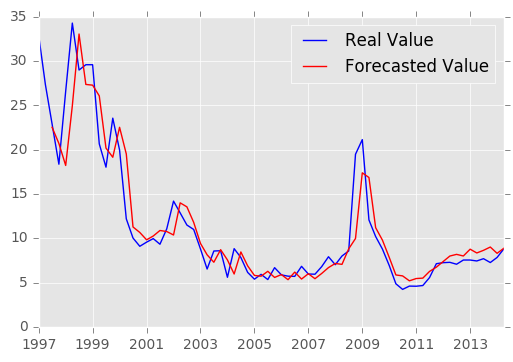

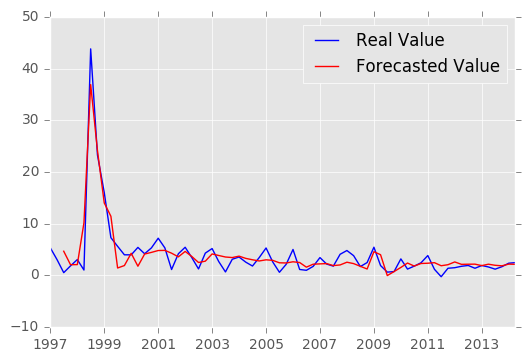

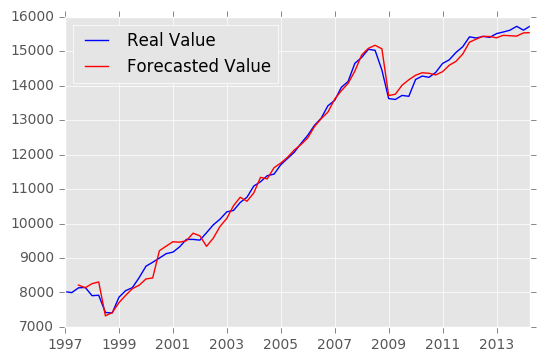

In [58]:
nn_result_as = {'in':scaler_back(nn_result['in'], m, s)[train_real.columns.tolist()], 
                'out':scaler_back(nn_result['out'], m, s)[train_real.columns.tolist()]}
print(error(nn_result_as['out']['stir'], test_real['stir']))
print(error(nn_result_as['out']['infr'], test_real['infr']))
print(error(nn_result_as['out']['gdp'], test_real['gdp']))

plot_compar(nn_result_as['out']['stir'], test_real['stir'])
plot_compar(nn_result_as['out']['infr'], test_real['infr'])
plot_compar(nn_result_as['out']['gdp'], test_real['gdp'])
plot_compar(nn_result_as['in']['stir'], train_real['stir'])
plot_compar(nn_result_as['in']['infr'], train_real['infr'])
plot_compar(nn_result_as['in']['gdp'], train_real['gdp'])

Второй запуск (не на разницах)

In [59]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
nn_result = nn_model(train_nn_x, train_nn_y, 
                     n_feat=3, lag=LAG, steps=STEPS, model=nn, 
                     years=train_nn_y.index, 
                     epoch=600)
nn_result_as = {'in':scaler_back(nn_result['in'], m, s)[train_real.columns.tolist()], 
                'out':scaler_back(nn_result['out'], m, s)[train_real.columns.tolist()]}

Epoch 1/600
0s - loss: 1.3435
Epoch 2/600
0s - loss: 1.0983
Epoch 3/600
0s - loss: 1.0045
Epoch 4/600
0s - loss: 0.9467
Epoch 5/600
0s - loss: 0.9042
Epoch 6/600
0s - loss: 0.8671
Epoch 7/600
0s - loss: 0.8283
Epoch 8/600
0s - loss: 0.7891
Epoch 9/600
0s - loss: 0.7512
Epoch 10/600
0s - loss: 0.7091
Epoch 11/600
0s - loss: 0.6724
Epoch 12/600
0s - loss: 0.6379
Epoch 13/600
0s - loss: 0.6068
Epoch 14/600
0s - loss: 0.5772
Epoch 15/600
0s - loss: 0.5534
Epoch 16/600
0s - loss: 0.5311
Epoch 17/600
0s - loss: 0.5139
Epoch 18/600
0s - loss: 0.4996
Epoch 19/600
0s - loss: 0.4874
Epoch 20/600
0s - loss: 0.4787
Epoch 21/600
0s - loss: 0.4703
Epoch 22/600
0s - loss: 0.4658
Epoch 23/600
0s - loss: 0.4581
Epoch 24/600
0s - loss: 0.4525
Epoch 25/600
0s - loss: 0.4485
Epoch 26/600
0s - loss: 0.4441
Epoch 27/600
0s - loss: 0.4391
Epoch 28/600
0s - loss: 0.4357
Epoch 29/600
0s - loss: 0.4325
Epoch 30/600
0s - loss: 0.4275
Epoch 31/600
0s - loss: 0.4238
Epoch 32/600
0s - loss: 0.4218
Epoch 33/600
0s -

{'mse': 3.7129191500743852, 'mae': 1.6562352596014795, 'rmse': 1.9268936530266494}
{'mse': 4.0168278269584681, 'mae': 1.3313908469464368, 'rmse': 2.0042025414010602}
{'mse': 3765210.8179612504, 'mae': 1682.1267663998956, 'rmse': 1940.4151148559038}


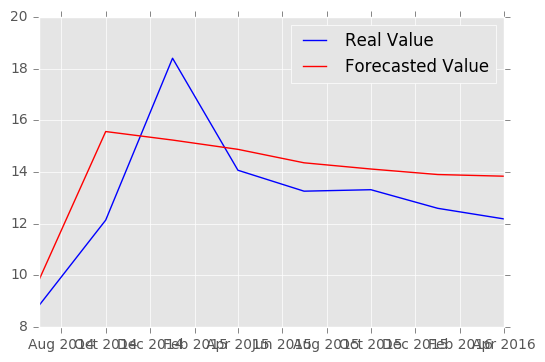

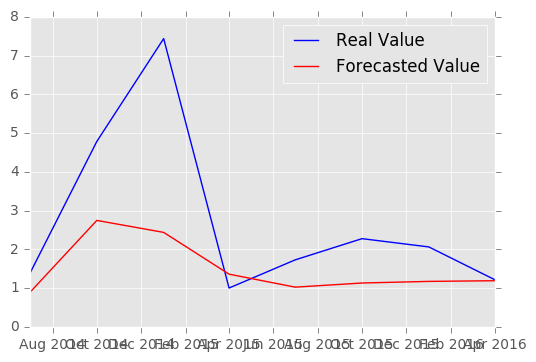

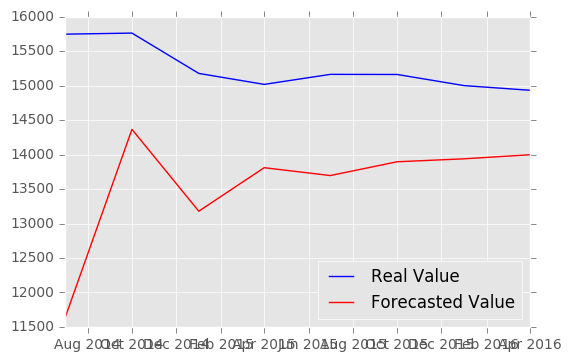

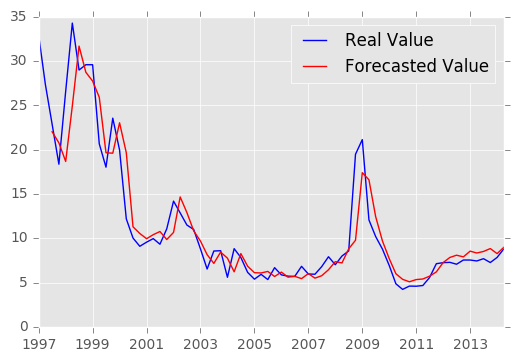

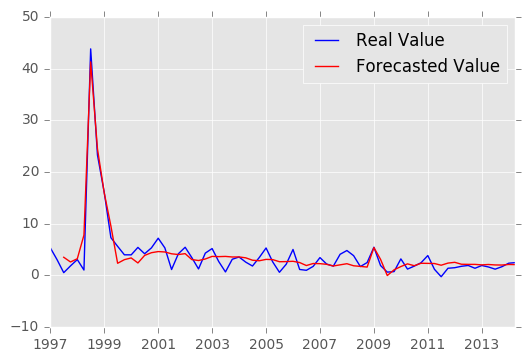

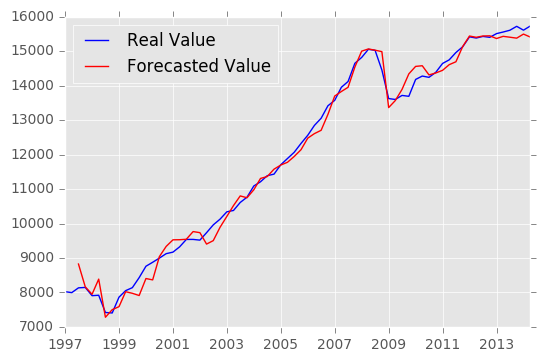

In [60]:
print(error(nn_result_as['out']['stir'], test_real['stir']))
print(error(nn_result_as['out']['infr'], test_real['infr']))
print(error(nn_result_as['out']['gdp'], test_real['gdp']))

plot_compar(nn_result_as['out']['stir'], test_real['stir'])
plot_compar(nn_result_as['out']['infr'], test_real['infr'])
plot_compar(nn_result_as['out']['gdp'], test_real['gdp'])
plot_compar(nn_result_as['in']['stir'], train_real['stir'])
plot_compar(nn_result_as['in']['infr'], train_real['infr'])
plot_compar(nn_result_as['in']['gdp'], train_real['gdp'])

С DropOut

In [61]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
nn_result = nn_model(train_nn_x, train_nn_y, 
                     n_feat=3, lag=LAG, steps=STEPS, model=nn, 
                     years=train_nn_y.index, 
                     epoch=600)
nn_result_as = {'in':scaler_back(nn_result['in'], m, s)[train_real.columns.tolist()], 
                'out':scaler_back(nn_result['out'], m, s)[train_real.columns.tolist()]}

Epoch 1/600
0s - loss: 0.9797
Epoch 2/600
0s - loss: 0.9302
Epoch 3/600
0s - loss: 0.8876
Epoch 4/600
0s - loss: 0.8469
Epoch 5/600
0s - loss: 0.8086
Epoch 6/600
0s - loss: 0.7671
Epoch 7/600
0s - loss: 0.7250
Epoch 8/600
0s - loss: 0.6879
Epoch 9/600
0s - loss: 0.6459
Epoch 10/600
0s - loss: 0.6126
Epoch 11/600
0s - loss: 0.5822
Epoch 12/600
0s - loss: 0.5542
Epoch 13/600
0s - loss: 0.5306
Epoch 14/600
0s - loss: 0.5112
Epoch 15/600
0s - loss: 0.4934
Epoch 16/600
0s - loss: 0.4805
Epoch 17/600
0s - loss: 0.4705
Epoch 18/600
0s - loss: 0.4615
Epoch 19/600
0s - loss: 0.4527
Epoch 20/600
0s - loss: 0.4476
Epoch 21/600
0s - loss: 0.4442
Epoch 22/600
0s - loss: 0.4380
Epoch 23/600
0s - loss: 0.4348
Epoch 24/600
0s - loss: 0.4327
Epoch 25/600
0s - loss: 0.4269
Epoch 26/600
0s - loss: 0.4232
Epoch 27/600
0s - loss: 0.4207
Epoch 28/600
0s - loss: 0.4159
Epoch 29/600
0s - loss: 0.4135
Epoch 30/600
0s - loss: 0.4130
Epoch 31/600
0s - loss: 0.4071
Epoch 32/600
0s - loss: 0.4042
Epoch 33/600
0s -

{'mse': 40.78518548945253, 'mae': 5.9174098087469895, 'rmse': 6.3863280129862208}
{'mse': 12.035441546479667, 'mae': 2.3963565828302005, 'rmse': 3.4692133901620505}
{'mse': 8412044.752881676, 'mae': 2168.3462176736411, 'rmse': 2900.352522174102}


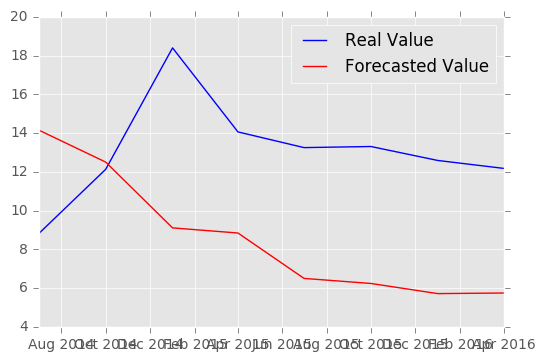

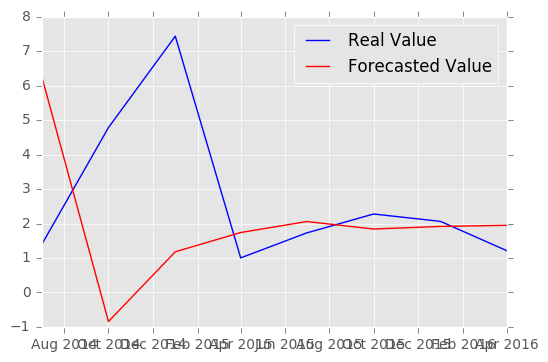

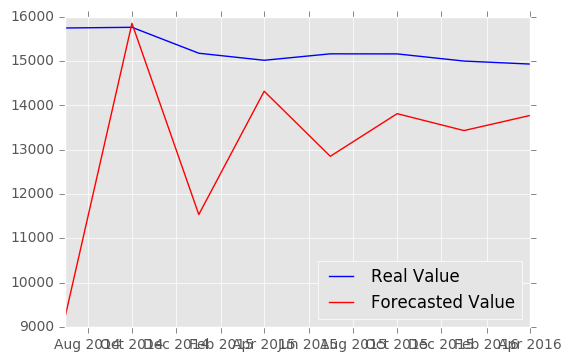

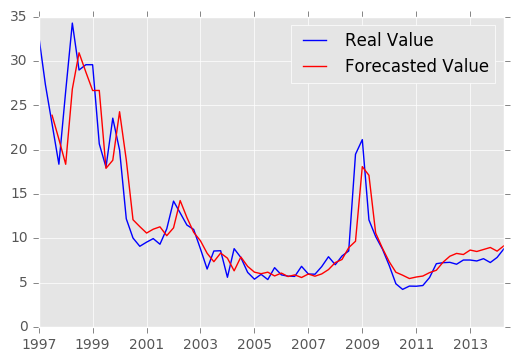

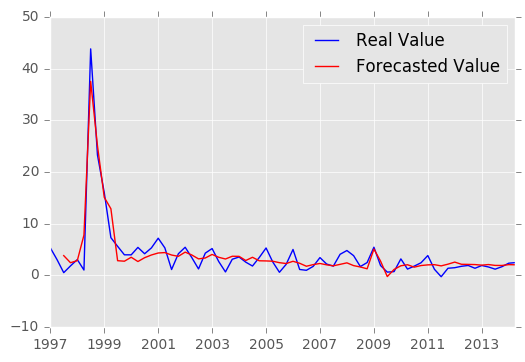

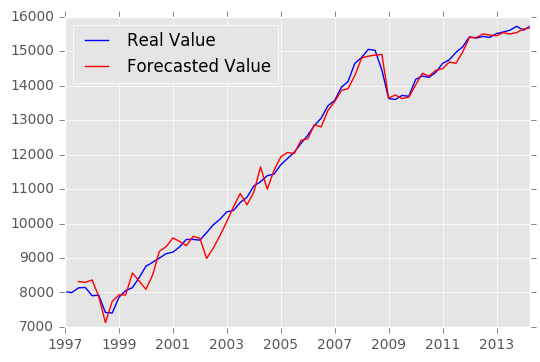

In [62]:
print(error(nn_result_as['out']['stir'], test_real['stir']))
print(error(nn_result_as['out']['infr'], test_real['infr']))
print(error(nn_result_as['out']['gdp'], test_real['gdp']))

plot_compar(nn_result_as['out']['stir'], test_real['stir'])
plot_compar(nn_result_as['out']['infr'], test_real['infr'])
plot_compar(nn_result_as['out']['gdp'], test_real['gdp'])
plot_compar(nn_result_as['in']['stir'], train_real['stir'])
plot_compar(nn_result_as['in']['infr'], train_real['infr'])
plot_compar(nn_result_as['in']['gdp'], train_real['gdp'])

## Hybrid

In [63]:
def hybrid_model(train, lags, steps, model_nn, years=True, epoch=100, period='m'):
    n_feat = len(train.columns)
    model = VAR(np.array(train))
    fitm = model.fit(maxlags=lags)
    var_result = fitm.forecast(y=np.array(train), steps=steps)
    
    resid_df = pd.DataFrame(fitm.resid)
    resid_df.columns = train.columns
    
    df_nn = nn_transform(resid_df, n=lags)
    ###
    df_nn_s, m, s = scaler(df_nn)
    ###
    train_nn_x = df_nn_s.iloc[:, n_feat:].copy()
    train_nn_y = df_nn_s.iloc[:, :n_feat].copy()
    model_nn.fit(np.array(train_nn_x), np.array(train_nn_y),
           nb_epoch=epoch, 
           verbose=2,
           batch_size=1)
    nn_result = nn_predict(model_nn, resid_df, lags=lags, steps=steps)
    ###
    nn_result_as = scaler_back(nn_result, m, s)[train.columns.tolist()]
    ###
    hybrid_result = pd.DataFrame(var_result + nn_result_as.as_matrix())
    hybrid_result.columns = train.columns
    
    b=1
    s=1
    p=steps
    if period=='q':
        p = steps*3
        s=3
        b=3
    
    if years == True:
        ind = [datetime.strptime(str(train.tail(1).index.tolist()[0])[:7], '%Y-%m') + relativedelta(months=i) \
               for i in range(b, p+1, s)]
        hybrid_result.index = ind
    return hybrid_result

In [64]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)

In [65]:
hybrid_result = hybrid_model(train, lags=LAG, steps=STEPS, model_nn=nn, years=True, epoch=200, period='q')

Epoch 1/200
0s - loss: 1.2078
Epoch 2/200
0s - loss: 1.0834
Epoch 3/200
0s - loss: 1.0271
Epoch 4/200
0s - loss: 1.0065
Epoch 5/200
0s - loss: 0.9961
Epoch 6/200
0s - loss: 0.9928
Epoch 7/200
0s - loss: 0.9890
Epoch 8/200
0s - loss: 0.9905
Epoch 9/200
0s - loss: 0.9894
Epoch 10/200
0s - loss: 0.9884
Epoch 11/200
0s - loss: 0.9901
Epoch 12/200
0s - loss: 0.9901
Epoch 13/200
0s - loss: 0.9885
Epoch 14/200
0s - loss: 0.9910
Epoch 15/200
0s - loss: 0.9878
Epoch 16/200
0s - loss: 0.9885
Epoch 17/200
0s - loss: 0.9880
Epoch 18/200
0s - loss: 0.9867
Epoch 19/200
0s - loss: 0.9866
Epoch 20/200
0s - loss: 0.9869
Epoch 21/200
0s - loss: 0.9875
Epoch 22/200
0s - loss: 0.9854
Epoch 23/200
0s - loss: 0.9876
Epoch 24/200
0s - loss: 0.9854
Epoch 25/200
0s - loss: 0.9887
Epoch 26/200
0s - loss: 0.9857
Epoch 27/200
0s - loss: 0.9852
Epoch 28/200
0s - loss: 0.9841
Epoch 29/200
0s - loss: 0.9854
Epoch 30/200
0s - loss: 0.9840
Epoch 31/200
0s - loss: 0.9883
Epoch 32/200
0s - loss: 0.9821
Epoch 33/200
0s -

{'mse': 13.820899024731293, 'mae': 2.6943733484279986, 'rmse': 3.7176469741936624}
{'mse': 12.733910028480123, 'mae': 2.7964437827593609, 'rmse': 3.5684604563424998}
{'mse': 104012.94856603473, 'mae': 227.87919454277906, 'rmse': 322.51038520648405}


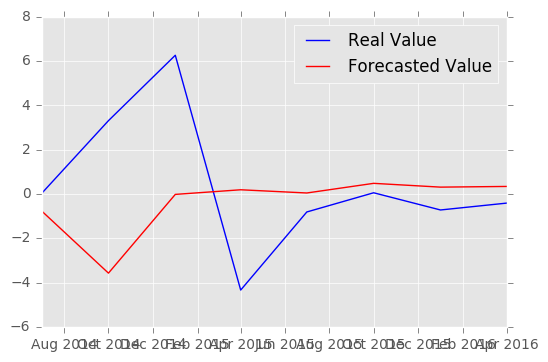

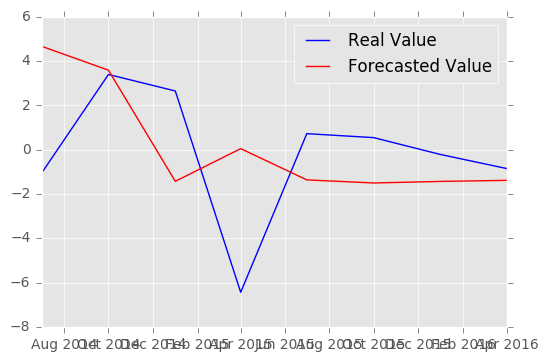

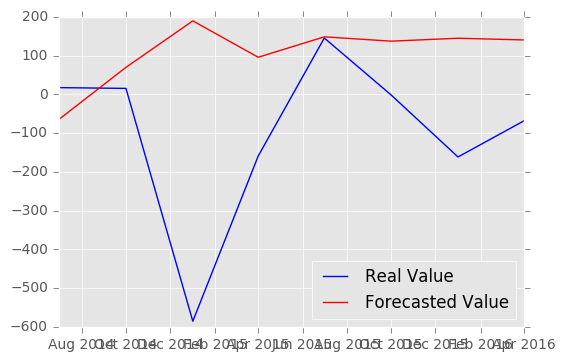

In [66]:
print(error(hybrid_result['stir'], test['stir']))
print(error(hybrid_result['infr'], test['infr']))
print(error(hybrid_result['gdp'], test['gdp']))
plot_compar(hybrid_result['stir'], test['stir'])
plot_compar(hybrid_result['infr'], test['infr'])
plot_compar(hybrid_result['gdp'], test['gdp'])

{'mse': 71.77326504523522, 'mae': 7.7557289172748174, 'rmse': 8.4719103539423273}
{'mse': 26.482014469164469, 'mae': 4.7073305800726821, 'rmse': 5.1460678648036184}
{'mse': 1094421.0110823072, 'mae': 890.14943648434405, 'rmse': 1046.145788636702}


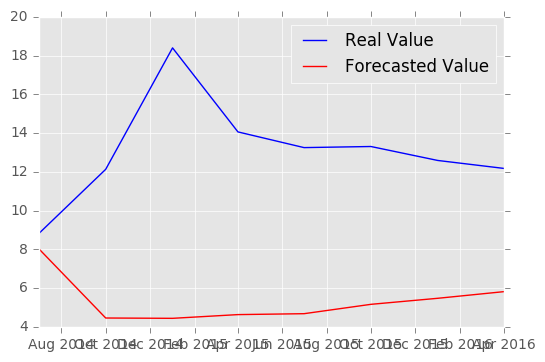

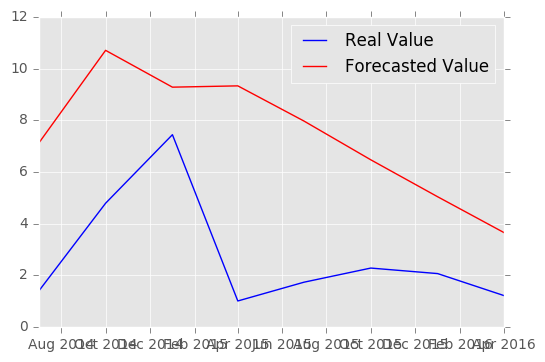

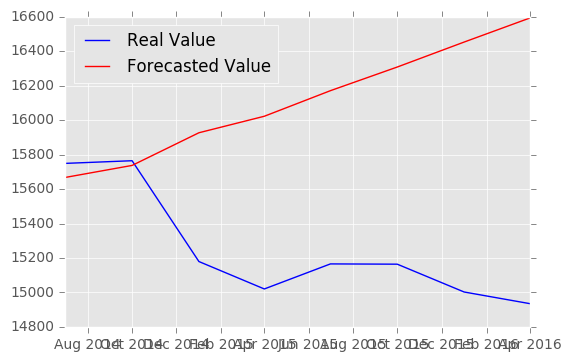

In [67]:
hybrid_undiff_out = undiff(previous_df=train_real, diff_df=hybrid_result)
print(error(hybrid_undiff_out['stir'], test_real['stir']))
print(error(hybrid_undiff_out['infr'], test_real['infr']))
print(error(hybrid_undiff_out['gdp'], test_real['gdp']))
plot_compar(hybrid_undiff_out['stir'], test_real['stir'])
plot_compar(hybrid_undiff_out['infr'], test_real['infr'])
plot_compar(hybrid_undiff_out['gdp'], test_real['gdp'])

Второй запуск

In [68]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
hybrid_result = hybrid_model(train, lags=LAG, steps=STEPS, model_nn=nn, years=True, epoch=200, period='q')

Epoch 1/200
0s - loss: 1.1129
Epoch 2/200
0s - loss: 1.0287
Epoch 3/200
0s - loss: 1.0009
Epoch 4/200
0s - loss: 0.9903
Epoch 5/200
0s - loss: 0.9903
Epoch 6/200
0s - loss: 0.9849
Epoch 7/200
0s - loss: 0.9865
Epoch 8/200
0s - loss: 0.9880
Epoch 9/200
0s - loss: 0.9865
Epoch 10/200
0s - loss: 0.9849
Epoch 11/200
0s - loss: 0.9846
Epoch 12/200
0s - loss: 0.9825
Epoch 13/200
0s - loss: 0.9842
Epoch 14/200
0s - loss: 0.9851
Epoch 15/200
0s - loss: 0.9819
Epoch 16/200
0s - loss: 0.9839
Epoch 17/200
0s - loss: 0.9822
Epoch 18/200
0s - loss: 0.9784
Epoch 19/200
0s - loss: 0.9813
Epoch 20/200
0s - loss: 0.9828
Epoch 21/200
0s - loss: 0.9821
Epoch 22/200
0s - loss: 0.9789
Epoch 23/200
0s - loss: 0.9765
Epoch 24/200
0s - loss: 0.9783
Epoch 25/200
0s - loss: 0.9760
Epoch 26/200
0s - loss: 0.9761
Epoch 27/200
0s - loss: 0.9745
Epoch 28/200
0s - loss: 0.9763
Epoch 29/200
0s - loss: 0.9775
Epoch 30/200
0s - loss: 0.9763
Epoch 31/200
0s - loss: 0.9736
Epoch 32/200
0s - loss: 0.9757
Epoch 33/200
0s -

{'mse': 13.658789973889945, 'mae': 2.7254669350758682, 'rmse': 3.6957800223890418}
{'mse': 12.044181507396846, 'mae': 2.6583791126865797, 'rmse': 3.470472807471173}
{'mse': 97779.368496680472, 'mae': 224.32368737637341, 'rmse': 312.69692754595536}


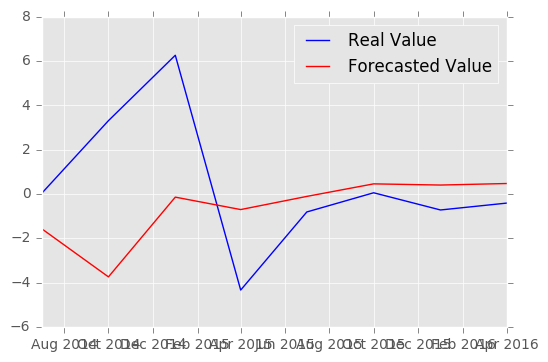

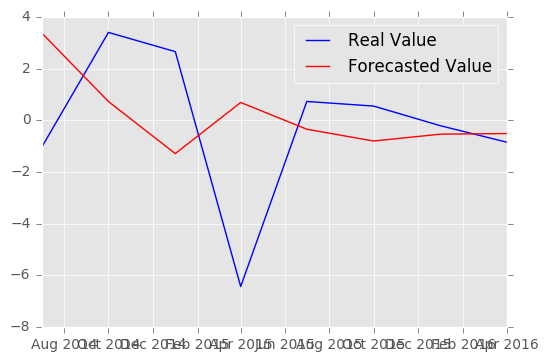

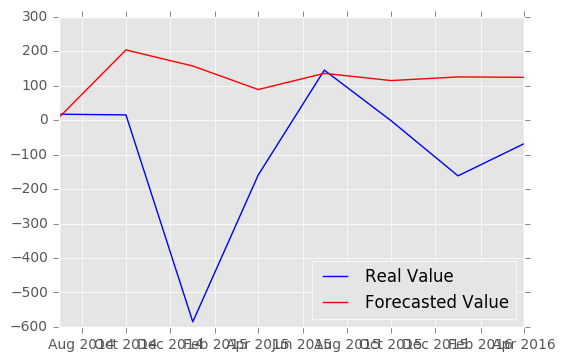

In [69]:
print(error(hybrid_result['stir'], test['stir']))
print(error(hybrid_result['infr'], test['infr']))
print(error(hybrid_result['gdp'], test['gdp']))
plot_compar(hybrid_result['stir'], test['stir'])
plot_compar(hybrid_result['infr'], test['infr'])
plot_compar(hybrid_result['gdp'], test['gdp'])

{'mse': 101.0877855112229, 'mae': 9.4028940821339635, 'rmse': 10.054242164938286}
{'mse': 10.531320415943789, 'mae': 3.0489226950991482, 'rmse': 3.245199595701902}
{'mse': 1346530.107743568, 'mae': 1005.3555275090769, 'rmse': 1160.4008392549395}


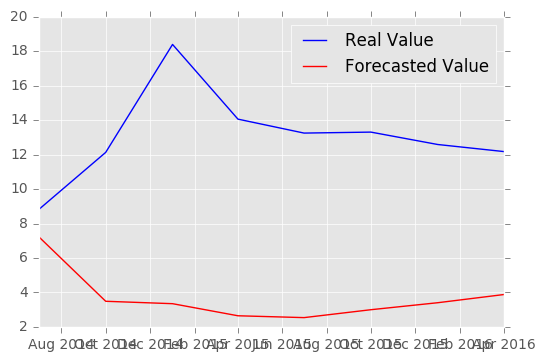

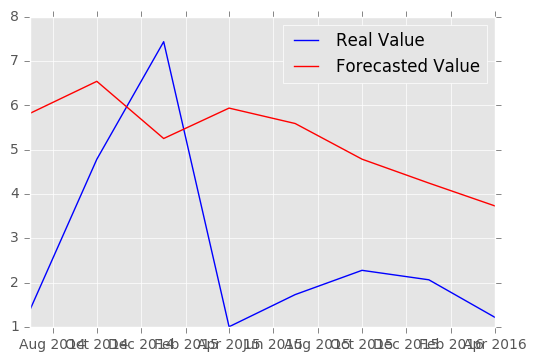

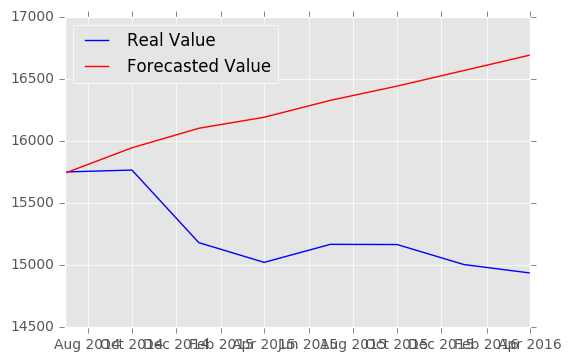

In [70]:
hybrid_undiff_out = undiff(previous_df=train_real, diff_df=hybrid_result)
print(error(hybrid_undiff_out['stir'], test_real['stir']))
print(error(hybrid_undiff_out['infr'], test_real['infr']))
print(error(hybrid_undiff_out['gdp'], test_real['gdp']))
plot_compar(hybrid_undiff_out['stir'], test_real['stir'])
plot_compar(hybrid_undiff_out['infr'], test_real['infr'])
plot_compar(hybrid_undiff_out['gdp'], test_real['gdp'])

С DropOut

In [71]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
hybrid_result = hybrid_model(train, lags=LAG, steps=STEPS, model_nn=nn, years=True, epoch=200, period='q')

Epoch 1/200
0s - loss: 2.8847
Epoch 2/200
0s - loss: 2.0978
Epoch 3/200
0s - loss: 1.6828
Epoch 4/200
0s - loss: 1.3861
Epoch 5/200
0s - loss: 1.2091
Epoch 6/200
0s - loss: 1.1192
Epoch 7/200
0s - loss: 1.0691
Epoch 8/200
0s - loss: 1.0669
Epoch 9/200
0s - loss: 1.0258
Epoch 10/200
0s - loss: 1.0312
Epoch 11/200
0s - loss: 1.0232
Epoch 12/200
0s - loss: 1.0383
Epoch 13/200
0s - loss: 0.9779
Epoch 14/200
0s - loss: 0.9871
Epoch 15/200
0s - loss: 1.0397
Epoch 16/200
0s - loss: 0.9918
Epoch 17/200
0s - loss: 1.0101
Epoch 18/200
0s - loss: 0.9954
Epoch 19/200
0s - loss: 1.0305
Epoch 20/200
0s - loss: 0.9909
Epoch 21/200
0s - loss: 0.9956
Epoch 22/200
0s - loss: 0.9881
Epoch 23/200
0s - loss: 0.9893
Epoch 24/200
0s - loss: 1.0059
Epoch 25/200
0s - loss: 1.0037
Epoch 26/200
0s - loss: 0.9944
Epoch 27/200
0s - loss: 1.0228
Epoch 28/200
0s - loss: 1.0088
Epoch 29/200
0s - loss: 0.9674
Epoch 30/200
0s - loss: 0.9929
Epoch 31/200
0s - loss: 1.0284
Epoch 32/200
0s - loss: 0.9937
Epoch 33/200
0s -

{'mse': 10.374305303374589, 'mae': 2.1874684042779937, 'rmse': 3.2209168420458467}
{'mse': 11.028045554445619, 'mae': 2.5106950178878709, 'rmse': 3.3208501252609426}
{'mse': 93836.506403543637, 'mae': 225.46449096493899, 'rmse': 306.32744964097429}


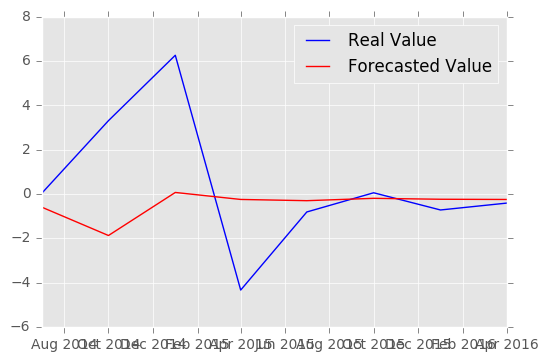

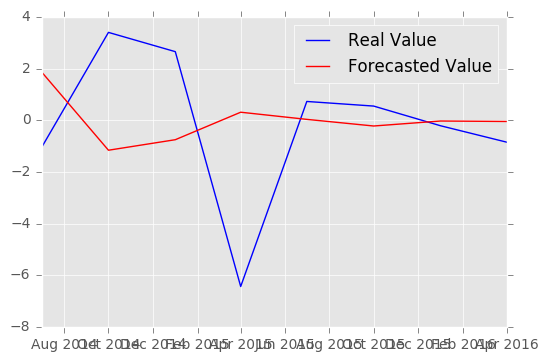

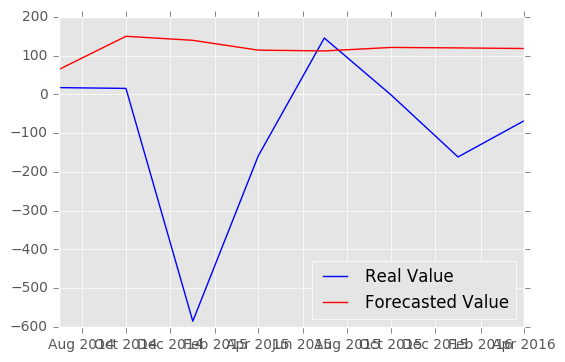

In [72]:
print(error(hybrid_result['stir'], test['stir']))
print(error(hybrid_result['infr'], test['infr']))
print(error(hybrid_result['gdp'], test['gdp']))
plot_compar(hybrid_result['stir'], test['stir'])
plot_compar(hybrid_result['infr'], test['infr'])
plot_compar(hybrid_result['gdp'], test['gdp'])

{'mse': 56.757367892676186, 'mae': 6.941665275283432, 'rmse': 7.5337485950007776}
{'mse': 5.2890327472163285, 'mae': 1.7726241784003358, 'rmse': 2.299789718043006}
{'mse': 1324567.5920021734, 'mae': 1002.2930694625268, 'rmse': 1150.8986019637757}


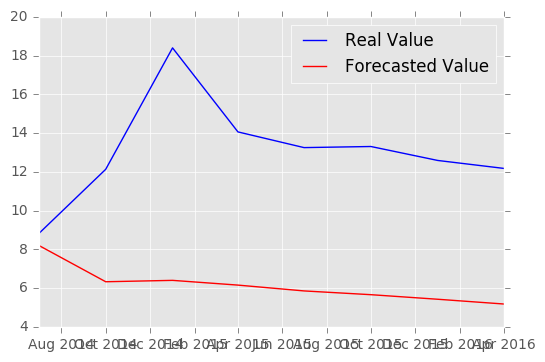

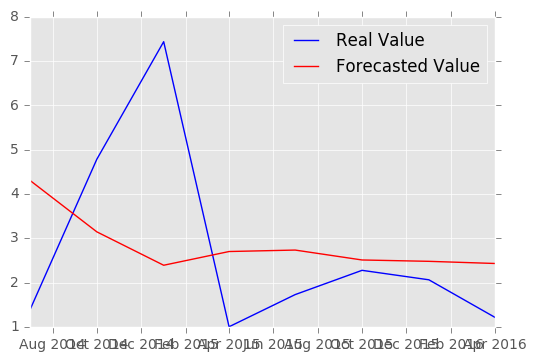

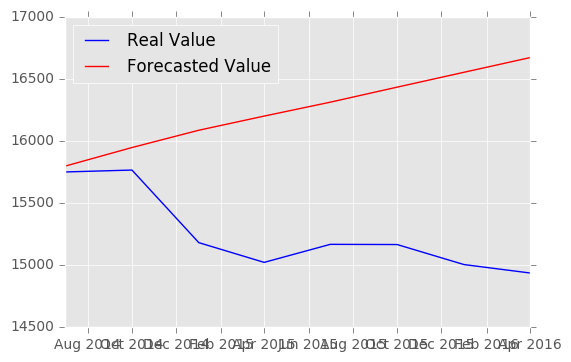

In [73]:
hybrid_undiff_out = undiff(previous_df=train_real, diff_df=hybrid_result)
print(error(hybrid_undiff_out['stir'], test_real['stir']))
print(error(hybrid_undiff_out['infr'], test_real['infr']))
print(error(hybrid_undiff_out['gdp'], test_real['gdp']))
plot_compar(hybrid_undiff_out['stir'], test_real['stir'])
plot_compar(hybrid_undiff_out['infr'], test_real['infr'])
plot_compar(hybrid_undiff_out['gdp'], test_real['gdp'])

### Hybrid_full

In [74]:
#def hybrid_model(train, lags, steps, model_nn, years=True, epoch=100, period='m'):
# lags = LAG
# steps=STEPS
# model_nn=nn
# years=True
# epoch=200
# period='q'

def hybrid_model_undiff(train, train_real, lags, steps, model_nn, years=True, epoch=100, period='m'):
    n_feat = len(train.columns)
    model = VAR(np.array(train))
    fitm = model.fit(maxlags=lags)
    var_result = fitm.forecast(y=np.array(train), steps=steps)
    var_in = undiff(previous_df=train_real.head(1), diff_df=pd.DataFrame(fitm.fittedvalues))
    var_out = undiff(previous_df=train_real, diff_df=pd.DataFrame(var_result))
    resid_df = pd.DataFrame(train_real.iloc[lags+1:, :].as_matrix() - var_in.as_matrix())
    resid_df.columns = train.columns

    df_nn = nn_transform(resid_df, n=lags)
    ###
    df_nn_s, m, s = scaler(df_nn)
    ###
    train_nn_x = df_nn_s.iloc[:, n_feat:].copy()
    train_nn_y = df_nn_s.iloc[:, :n_feat].copy()
    model_nn.fit(np.array(train_nn_x), np.array(train_nn_y),
           nb_epoch=epoch, 
           verbose=2,
           batch_size=1)
    nn_result = nn_predict(model_nn, resid_df, lags=lags, steps=steps)
    ###
    nn_result_as = scaler_back(nn_result, m, s)[train.columns.tolist()]
    ###
    hybrid_result = pd.DataFrame(var_out.as_matrix() + nn_result_as.as_matrix())
    hybrid_result.columns = train.columns

    b=1
    s=1
    p=steps
    if period=='q':
        p = steps*3
        s=3
        b=3

    if years == True:
        ind = [datetime.strptime(str(train.tail(1).index.tolist()[0])[:7], '%Y-%m') + relativedelta(months=i) \
               for i in range(b, p+1, s)]
        hybrid_result.index = ind
    return hybrid_result

Первый запуск

In [75]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
hybrid_result_undiff = hybrid_model_undiff(train, train_real, lags=LAG, steps=STEPS, 
                                    model_nn=nn, years=True, epoch=500, period='q')

Epoch 1/500
0s - loss: 1.3051
Epoch 2/500
0s - loss: 1.0870
Epoch 3/500
0s - loss: 0.9928
Epoch 4/500
0s - loss: 0.9410
Epoch 5/500
0s - loss: 0.9081
Epoch 6/500
0s - loss: 0.8773
Epoch 7/500
0s - loss: 0.8511
Epoch 8/500
0s - loss: 0.8240
Epoch 9/500
0s - loss: 0.7946
Epoch 10/500
0s - loss: 0.7693
Epoch 11/500
0s - loss: 0.7391
Epoch 12/500
0s - loss: 0.7137
Epoch 13/500
0s - loss: 0.6851
Epoch 14/500
0s - loss: 0.6595
Epoch 15/500
0s - loss: 0.6351
Epoch 16/500
0s - loss: 0.6075
Epoch 17/500
0s - loss: 0.5841
Epoch 18/500
0s - loss: 0.5629
Epoch 19/500
0s - loss: 0.5397
Epoch 20/500
0s - loss: 0.5179
Epoch 21/500
0s - loss: 0.5004
Epoch 22/500
0s - loss: 0.4824
Epoch 23/500
0s - loss: 0.4671
Epoch 24/500
0s - loss: 0.4507
Epoch 25/500
0s - loss: 0.4369
Epoch 26/500
0s - loss: 0.4224
Epoch 27/500
0s - loss: 0.4093
Epoch 28/500
0s - loss: 0.3980
Epoch 29/500
0s - loss: 0.3854
Epoch 30/500
0s - loss: 0.3754
Epoch 31/500
0s - loss: 0.3658
Epoch 32/500
0s - loss: 0.3572
Epoch 33/500
0s -

{'mse': 388.90914144690822, 'mae': 19.523339501533478, 'rmse': 19.720779433047472}
{'mse': 67.106564856665031, 'mae': 7.0146721473002369, 'rmse': 8.1918596702253783}
{'mse': 1121815.438945441, 'mae': 965.94034003469528, 'rmse': 1059.1578914144204}


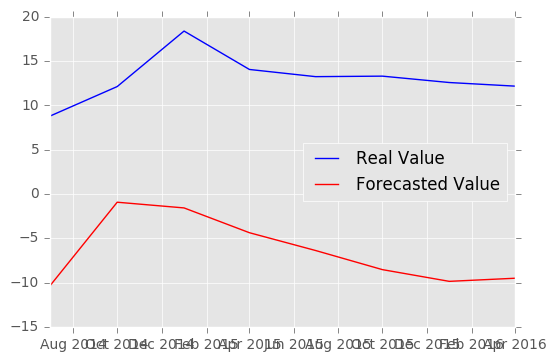

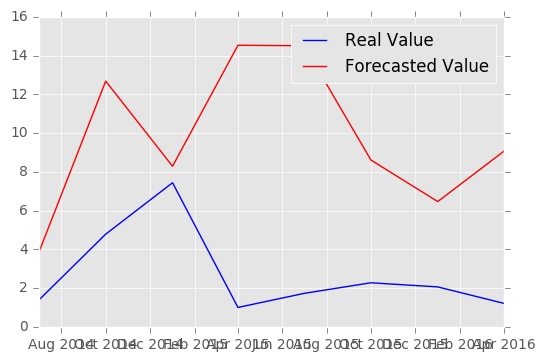

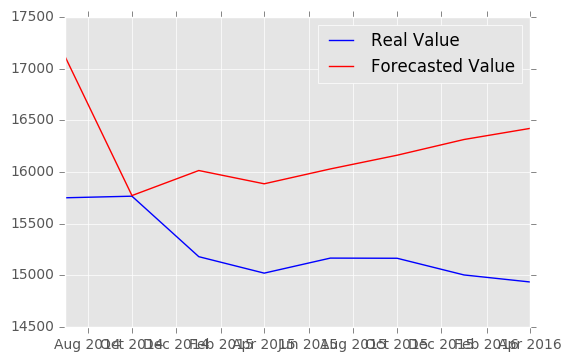

In [76]:
print(error(hybrid_result_undiff['stir'], test_real['stir']))
print(error(hybrid_result_undiff['infr'], test_real['infr']))
print(error(hybrid_result_undiff['gdp'], test_real['gdp']))
plot_compar(hybrid_result_undiff['stir'], test_real['stir'])
plot_compar(hybrid_result_undiff['infr'], test_real['infr'])
plot_compar(hybrid_result_undiff['gdp'], test_real['gdp'])

Второй запуск

In [77]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
hybrid_result_undiff = hybrid_model_undiff(train, train_real, lags=LAG, steps=STEPS, 
                                    model_nn=nn, years=True, epoch=500, period='q')

Epoch 1/500
0s - loss: 1.2264
Epoch 2/500
0s - loss: 1.0345
Epoch 3/500
0s - loss: 0.9495
Epoch 4/500
0s - loss: 0.9075
Epoch 5/500
0s - loss: 0.8740
Epoch 6/500
0s - loss: 0.8456
Epoch 7/500
0s - loss: 0.8238
Epoch 8/500
0s - loss: 0.7974
Epoch 9/500
0s - loss: 0.7739
Epoch 10/500
0s - loss: 0.7520
Epoch 11/500
0s - loss: 0.7260
Epoch 12/500
0s - loss: 0.7006
Epoch 13/500
0s - loss: 0.6774
Epoch 14/500
0s - loss: 0.6560
Epoch 15/500
0s - loss: 0.6313
Epoch 16/500
0s - loss: 0.6065
Epoch 17/500
0s - loss: 0.5865
Epoch 18/500
0s - loss: 0.5635
Epoch 19/500
0s - loss: 0.5424
Epoch 20/500
0s - loss: 0.5191
Epoch 21/500
0s - loss: 0.5002
Epoch 22/500
0s - loss: 0.4805
Epoch 23/500
0s - loss: 0.4629
Epoch 24/500
0s - loss: 0.4446
Epoch 25/500
0s - loss: 0.4275
Epoch 26/500
0s - loss: 0.4117
Epoch 27/500
0s - loss: 0.3986
Epoch 28/500
0s - loss: 0.3847
Epoch 29/500
0s - loss: 0.3728
Epoch 30/500
0s - loss: 0.3622
Epoch 31/500
0s - loss: 0.3521
Epoch 32/500
0s - loss: 0.3440
Epoch 33/500
0s -

{'mse': 261.07647205174999, 'mae': 15.526237210068867, 'rmse': 16.15786099865171}
{'mse': 192.57379172765752, 'mae': 11.909369134354019, 'rmse': 13.877095939988941}
{'mse': 787358.28097312991, 'mae': 795.10023231330433, 'rmse': 887.33211424648096}


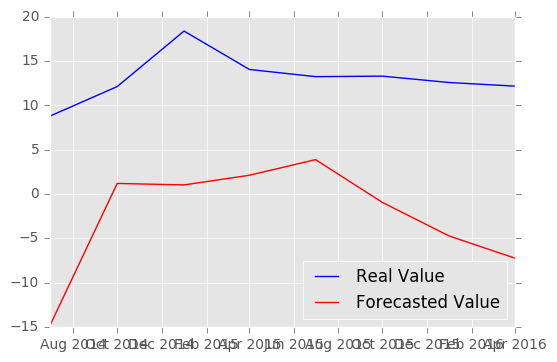

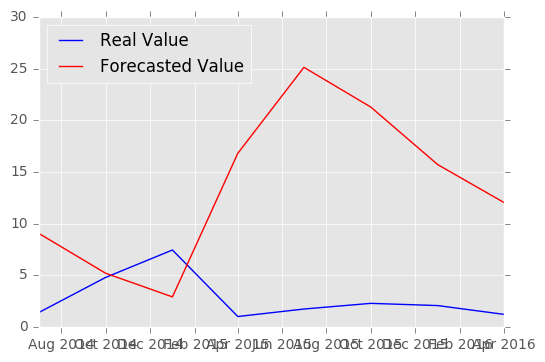

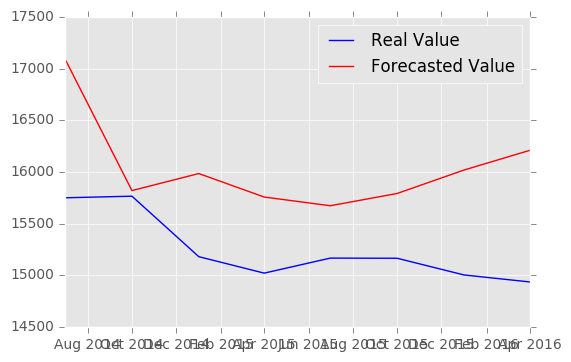

In [78]:
print(error(hybrid_result_undiff['stir'], test_real['stir']))
print(error(hybrid_result_undiff['infr'], test_real['infr']))
print(error(hybrid_result_undiff['gdp'], test_real['gdp']))
plot_compar(hybrid_result_undiff['stir'], test_real['stir'])
plot_compar(hybrid_result_undiff['infr'], test_real['infr'])
plot_compar(hybrid_result_undiff['gdp'], test_real['gdp'])

С DropOut

In [79]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
hybrid_result_undiff = hybrid_model_undiff(train, train_real, lags=LAG, steps=STEPS, 
                                    model_nn=nn, years=True, epoch=500, period='q')

Epoch 1/500
0s - loss: 1.3061
Epoch 2/500
0s - loss: 1.1413
Epoch 3/500
0s - loss: 1.0513
Epoch 4/500
0s - loss: 1.0252
Epoch 5/500
0s - loss: 1.0020
Epoch 6/500
0s - loss: 0.9846
Epoch 7/500
0s - loss: 0.9842
Epoch 8/500
0s - loss: 0.9867
Epoch 9/500
0s - loss: 0.9730
Epoch 10/500
0s - loss: 0.9400
Epoch 11/500
0s - loss: 0.9870
Epoch 12/500
0s - loss: 0.9326
Epoch 13/500
0s - loss: 0.9619
Epoch 14/500
0s - loss: 0.9296
Epoch 15/500
0s - loss: 0.9253
Epoch 16/500
0s - loss: 0.9475
Epoch 17/500
0s - loss: 0.9166
Epoch 18/500
0s - loss: 0.9421
Epoch 19/500
0s - loss: 0.9449
Epoch 20/500
0s - loss: 0.8831
Epoch 21/500
0s - loss: 0.8989
Epoch 22/500
0s - loss: 0.9076
Epoch 23/500
0s - loss: 0.9089
Epoch 24/500
0s - loss: 0.9171
Epoch 25/500
0s - loss: 0.8638
Epoch 26/500
0s - loss: 0.8952
Epoch 27/500
0s - loss: 0.8252
Epoch 28/500
0s - loss: 0.8638
Epoch 29/500
0s - loss: 0.8626
Epoch 30/500
0s - loss: 0.8123
Epoch 31/500
0s - loss: 0.8176
Epoch 32/500
0s - loss: 0.8494
Epoch 33/500
0s -

{'mse': 446.80786954039775, 'mae': 21.020002631804179, 'rmse': 21.137830294058038}
{'mse': 9.3862798450272713, 'mae': 2.5525126770133548, 'rmse': 3.0637036157284001}
{'mse': 1959087.2997078653, 'mae': 1324.6144149003876, 'rmse': 1399.6739976536912}


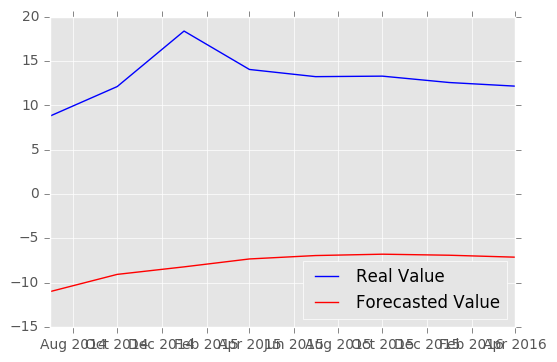

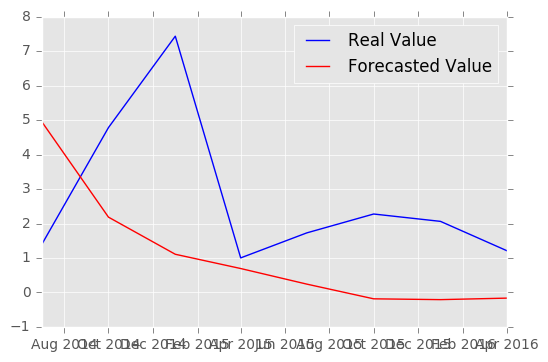

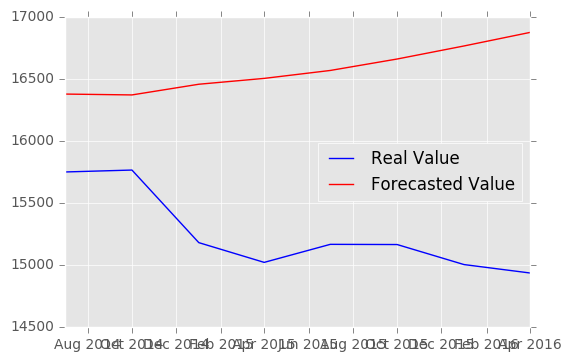

In [80]:
print(error(hybrid_result_undiff['stir'], test_real['stir']))
print(error(hybrid_result_undiff['infr'], test_real['infr']))
print(error(hybrid_result_undiff['gdp'], test_real['gdp']))
plot_compar(hybrid_result_undiff['stir'], test_real['stir'])
plot_compar(hybrid_result_undiff['infr'], test_real['infr'])
plot_compar(hybrid_result_undiff['gdp'], test_real['gdp'])